In [ ]:
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from helpers import delta_r, delta_phi, inv_mass_3p, cos_opening_angle, inv_mass, delta_eta
from samples import signal_samples
from helpers import files_from_dir, files_from_dirs
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
local_dir = "C:\\Users\\lucas\\Desktop\\PDM\\data\\HeavyNeutrino_trilepton\\HeavyNeutrino_trilepton_M-300_V-0p01_tau_NLO_tauhFilter_TuneCP5_13TeV-madgraph-pythia8"
samples = files_from_dir(local_dir),
i_file = 1
tot_events = 0
overall_maxpt_mass = []
overall_minpt_mass = []
overall_mindr_mass = []
overall_maxdr_mass = []
overall_maxsolopt_mass = []
overall_minsolopt_mass = []


for file in samples[0]:
    events = NanoEventsFactory.from_root(file, schemaclass=NanoAODSchema).events()
    print(str(i_file)+"/"+str(len(samples[0])))
    i_file = i_file+1
    nb_events = len(events)
    tot_events = tot_events+nb_events
    events['weight'] = events.genWeight
    events['SelElectron'] = events.Electron[(events.Electron.pt > 20.) & (events.Electron.mvaFall17V2Iso_WP90 > 0.5)]
    events['SelMuon'] = events.Muon[(events.Muon.pt > 24.) & (events.Muon.mediumPromptId) & (events.Muon.pfRelIso03_all < 0.2) & (np.abs(events.Muon.dxy) < 0.005)]
    muon1, electron1 = ak.unzip(ak.cartesian([events.SelMuon, events.SelElectron], nested=True))
    match1 = ak.any(muon1.jetIdx == electron1.jetIdx, axis=-1, mask_identity=False)
    events['SelMuon'] = events.SelMuon[(~(match1))]  
    events['SelTau'] = events.Tau[(events.Tau.pt > 20.) & (events.Tau.idDeepTau2017v2p1VSmu > 0.5) & (events.Tau.idDeepTau2017v2p1VSe > 0.5) & (events.Tau.idDeepTau2017v2p1VSjet >=8)]
    tau2, electron2 = ak.unzip(ak.cartesian([events.SelTau, events.SelElectron], nested=True))
    match2 = ak.any(tau2.jetIdx == electron2.jetIdx, axis=-1, mask_identity=False)
    tau3, electron3 = ak.unzip(ak.cartesian([events.SelTau, events.SelElectron], nested=True))
    match3 = ak.any(tau3.jetIdx == electron3.jetIdx, axis=-1, mask_identity=False)
    events['SelTau'] = events.SelTau[((~(match2) & ~(match3)) )]
    events = events[ak.num(events.SelElectron)+ak.num(events.SelMuon) + ak.num(events.SelTau) == 3]

    leptons = ak.concatenate([events.SelElectron, events.SelMuon,events.SelTau], axis = -1)
    by1 = np.ones(len(leptons), np.int8)
    l1 = ak.unflatten(leptons[:,0],by1)
    l2 = ak.unflatten(leptons[:,1],by1)
    l3 = ak.unflatten(leptons[:,2],by1)

    pair1 = ak.concatenate([l1, l2], axis = -1)
    pair2 = ak.concatenate([l1, l3], axis = -1)
    pair3 = ak.concatenate([l3, l2], axis = -1)

    pairs = ak.concatenate([pair1, pair2, pair3], axis = 1)
    pairs = ak.flatten(pairs)
    by2 = np.full(int(len(pairs)/2), 2,np.int8 )
    pairs = ak.unflatten(pairs,by2)
    by3 = np.full(int(len(pairs)/3), 3 ,np.int8)
    pairs = ak.unflatten(pairs, by3)

    pairs = pairs[pairs[:,:,0].charge + pairs[:,:,1].charge == 0]
    pairs = pairs[ak.num(pairs) == 2]

    #combined tranverse momentum, take maximum
    pairs_maxpt1 = pairs[(pairs[:,0,1]+pairs[:,0,0]).pt <  (pairs[:,:,0]+pairs[:,:,1]).pt ]
    pairs_maxpt1 = ak.flatten(pairs_maxpt1, axis = -1)
    pairs_maxpt2 = pairs[(pairs[:,1,1]+pairs[:,1,0]).pt <  (pairs[:,:,0]+pairs[:,:,1]).pt ]
    pairs_maxpt2 = ak.flatten(pairs_maxpt2, axis = -1)
    pairs_maxpt = ak.concatenate([pairs_maxpt1,pairs_maxpt2], axis = -1)
    pairs_maxpt_mass = (pairs_maxpt[:,0] + pairs_maxpt[:,1]).mass
    overall_maxpt_mass.extend(pairs_maxpt_mass)
    
    
    #combined tranverse momentum, take minimum
    pairs_minpt1 = pairs[(pairs[:,0,1]+pairs[:,0,0]).pt >  (pairs[:,:,0]+pairs[:,:,1]).pt ]
    pairs_minpt1 = ak.flatten(pairs_minpt1, axis = -1)
    pairs_minpt2 = pairs[(pairs[:,1,1]+pairs[:,1,0]).pt >  (pairs[:,:,0]+pairs[:,:,1]).pt ]
    pairs_minpt2 = ak.flatten(pairs_minpt2, axis = -1)
    pairs_minpt = ak.concatenate([pairs_minpt1,pairs_minpt2], axis = -1)
    pairs_minpt_mass = (pairs_minpt[:,0] + pairs_minpt[:,1]).mass
    overall_minpt_mass.extend(pairs_minpt_mass)

    #combined dr, take minimum
    pairs_mindr1 = pairs[delta_r(pairs[:,0,1],pairs[:,0,0]) >  delta_r(pairs[:,:,0],pairs[:,:,1]) ]
    pairs_mindr1 = ak.flatten(pairs_mindr1, axis = -1)
    pairs_mindr2 = pairs[delta_r(pairs[:,1,1],pairs[:,1,0]) >  delta_r(pairs[:,:,0],pairs[:,:,1]) ]
    pairs_mindr2 = ak.flatten(pairs_mindr2, axis = -1)
    pairs_mindr = ak.concatenate([pairs_mindr1,pairs_mindr2], axis = -1)
    pairs_mindr_mass = (pairs_mindr[:,0] + pairs_mindr[:,1]).mass
    overall_mindr_mass.extend(pairs_mindr_mass)

    #combined dr, take maximum
    pairs_maxdr1 = pairs[delta_r(pairs[:,0,1],pairs[:,0,0]) <  delta_r(pairs[:,:,0],pairs[:,:,1]) ]
    pairs_maxdr1 = ak.flatten(pairs_maxdr1, axis = -1)
    pairs_maxdr2 = pairs[delta_r(pairs[:,1,1],pairs[:,1,0]) <  delta_r(pairs[:,:,0],pairs[:,:,1]) ]
    pairs_maxdr2 = ak.flatten(pairs_maxdr2, axis = -1)
    pairs_maxdr = ak.concatenate([pairs_maxdr1,pairs_maxdr2], axis = -1)
    pairs_maxdr_mass = (pairs_maxdr[:,0] + pairs_maxdr[:,1]).mass
    overall_maxdr_mass.extend(pairs_maxdr_mass)

    #sum of tranverse momentum, take maximum ( same as taking the pair with highest single momentum)
    pairs_maxsolopt1 = pairs[pairs[:,0,1].pt+pairs[:,0,0].pt <  pairs[:,:,0].pt+pairs[:,:,1].pt ]
    pairs_maxsolopt1 = ak.flatten(pairs_maxsolopt1, axis = -1)
    pairs_maxsolopt2 = pairs[pairs[:,1,1].pt+pairs[:,1,0].pt <  pairs[:,:,0].pt+pairs[:,:,1].pt ]
    pairs_maxsolopt2 = ak.flatten(pairs_maxsolopt2, axis = -1)
    pairs_maxsolopt = ak.concatenate([pairs_maxsolopt1,pairs_maxsolopt2], axis = -1)
    pairs_maxsolopt_mass = (pairs_maxsolopt[:,0] + pairs_maxsolopt[:,1]).mass
    overall_maxsolopt_mass.extend(pairs_maxsolopt_mass)

    #sum of tranverse momentum, take minimum ( same as taking the pair with lowest single momentum)
    pairs_minsolopt1 = pairs[pairs[:,0,1].pt+pairs[:,0,0].pt >  pairs[:,:,0].pt+pairs[:,:,1].pt ]
    pairs_minsolopt1 = ak.flatten(pairs_minsolopt1, axis = -1)
    pairs_minsolopt2 = pairs[pairs[:,1,1].pt+pairs[:,1,0].pt >  pairs[:,:,0].pt+pairs[:,:,1].pt ]
    pairs_minsolopt2 = ak.flatten(pairs_minsolopt2, axis = -1)
    pairs_minsolopt = ak.concatenate([pairs_minsolopt1,pairs_minsolopt2], axis = -1)
    pairs_minsolopt_mass = (pairs_minsolopt[:,0] + pairs_minsolopt[:,1]).mass
    overall_minsolopt_mass.extend(pairs_minsolopt_mass)






nbins = 100
plt.figure(figsize=(12,15))
plt.suptitle("HNL300")
plt.subplot(3, 2, 1)
plt.hist(pairs_maxpt_mass, bins = nbins)
plt.title("max pt of dilepton")
plt.xlabel('mass')
plt.ylabel('counts')
plt.subplot(3, 2, 2)
plt.hist(pairs_minpt_mass, bins = nbins)
plt.title("min pt of dilepton")
plt.xlabel('mass')
plt.ylabel('counts')
plt.subplot(3, 2, 3)
plt.hist(pairs_maxdr_mass, bins = nbins)
plt.title("max dr of dilepton")
plt.xlabel('mass')
plt.ylabel('counts')
plt.subplot(3, 2, 4)
plt.hist(pairs_mindr_mass, bins = nbins)
plt.title("min dr of dilepton")
plt.xlabel('mass')
plt.ylabel('counts')
plt.subplot(3, 2, 5)
plt.hist(pairs_maxsolopt_mass, bins = nbins)
plt.title("highest pt of single lepton")
plt.xlabel('mass')
plt.ylabel('counts')
plt.subplot(3, 2, 6)
plt.hist(pairs_minsolopt_mass, bins = nbins)
plt.title("lowest pt of single lepton")
plt.xlabel('mass')
plt.ylabel('counts')
plt.savefig('HNL300_mass_which.pdf')  

plt.show()

    

In [189]:
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from helpers import delta_r, delta_phi, inv_mass_3p, cos_opening_angle, inv_mass, delta_eta
from samples import signal_samples
from helpers import files_from_dir, files_from_dirs
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
local_dir = "C:\\Users\\lucas\\Desktop\\PDM\\data\\HeavyNeutrino_trilepton\\HeavyNeutrino_trilepton_M-300_V-0p01_tau_NLO_tauhFilter_TuneCP5_13TeV-madgraph-pythia8"
samples = files_from_dir(local_dir),
i_file = 1
tot_events = 0


for file in samples[0]:
    events = NanoEventsFactory.from_root(file, schemaclass=NanoAODSchema).events()
    print(str(i_file)+"/"+str(len(samples[0])))
    i_file = i_file+1
    nb_events = len(events)
    tot_events = tot_events+nb_events
    events['weight'] = events.genWeight
    events['SelElectron'] = events.Electron[(events.Electron.pt > 20.) & (events.Electron.mvaFall17V2Iso_WP90 > 0.5)]
    events['SelMuon'] = events.Muon[(events.Muon.pt > 24.) & (events.Muon.mediumPromptId) & (events.Muon.pfRelIso03_all < 0.2) & (np.abs(events.Muon.dxy) < 0.005)]
    muon1, electron1 = ak.unzip(ak.cartesian([events.SelMuon, events.SelElectron], nested=True))
    match1 = ak.any(muon1.jetIdx == electron1.jetIdx, axis=-1, mask_identity=False)
    events['SelMuon'] = events.SelMuon[(~(match1))]  
    events['SelTau'] = events.Tau[(events.Tau.pt > 20.) & (events.Tau.idDeepTau2017v2p1VSmu > 0.5) & (events.Tau.idDeepTau2017v2p1VSe > 0.5) & (events.Tau.idDeepTau2017v2p1VSjet >=8)]
    tau2, electron2 = ak.unzip(ak.cartesian([events.SelTau, events.SelElectron], nested=True))
    match2 = ak.any(tau2.jetIdx == electron2.jetIdx, axis=-1, mask_identity=False)
    tau3, electron3 = ak.unzip(ak.cartesian([events.SelTau, events.SelElectron], nested=True))
    match3 = ak.any(tau3.jetIdx == electron3.jetIdx, axis=-1, mask_identity=False)
    events['SelTau'] = events.SelTau[((~(match2) & ~(match3)) )]
    events = events[ak.num(events.SelElectron)+ak.num(events.SelMuon) + ak.num(events.SelTau) == 3]

    leptons = ak.concatenate([events.SelElectron, events.SelMuon,events.SelTau], axis = -1)
    by1 = np.ones(len(leptons), np.int8)
    l1 = ak.unflatten(leptons[:,0],by1)
    l2 = ak.unflatten(leptons[:,1],by1)
    l3 = ak.unflatten(leptons[:,2],by1)

    pair1 = ak.concatenate([l1, l2], axis = -1)
    pair2 = ak.concatenate([l1, l3], axis = -1)
    pair3 = ak.concatenate([l3, l2], axis = -1)

    pairs = ak.concatenate([pair1, pair2, pair3], axis = 1)
    pairs = ak.flatten(pairs)
    by2 = np.full(int(len(pairs)/2), 2,np.int8 )
    pairs = ak.unflatten(pairs,by2)
    by3 = np.full(int(len(pairs)/3), 3 ,np.int8)
    pairs = ak.unflatten(pairs, by3)

    pairs = pairs[pairs[:,:,0].charge + pairs[:,:,1].charge == 0]
    pairs = pairs[ak.num(pairs) == 2]

    #combined tranverse momentum, take maximum
    pairs_maxpt1 = pairs[(pairs[:,0,1]+pairs[:,0,0]).pt <  (pairs[:,:,0]+pairs[:,:,1]).pt ]
    pairs_maxpt1 = ak.flatten(pairs_maxpt1, axis = -1)
    pairs_maxpt2 = pairs[(pairs[:,1,1]+pairs[:,1,0]).pt <  (pairs[:,:,0]+pairs[:,:,1]).pt ]
    pairs_maxpt2 = ak.flatten(pairs_maxpt2, axis = -1)
    pairs_maxpt = ak.concatenate([pairs_maxpt1,pairs_maxpt2], axis = -1)
    print(pairs_maxpt)    
    print(pairs_maxpt[0])
    print(pairs_maxpt[0,0])
    print(pairs_maxpt[:,0])
    pairs_maxpt_tt = pairs_maxpt[str(pairs_maxpt[:,0]) == 'boby']
    print(pairs_maxpt_tt)
    






    

1/1
[[Muon, Tau], [Electron, Tau], [Electron, Tau, ... Tau], [Tau, Tau], [Tau, Muon]]
[Muon, Tau]
Muon
[Muon, Electron, Electron, Electron, Muon, Muon, ... Muon, Electron, Tau, Tau, Tau]
[Muon, Tau]


In [16]:
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from helpers import delta_r, delta_phi, inv_mass_3p, cos_opening_angle, inv_mass, delta_eta
from samples import signal_samples
from helpers import files_from_dir, files_from_dirs
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
local_dir = "C:\\Users\\lucas\\Desktop\\PDM\\data\\HeavyNeutrino_trilepton\\HeavyNeutrino_trilepton_M-300_V-0p01_tau_NLO_tauhFilter_TuneCP5_13TeV-madgraph-pythia8"
samples = files_from_dir(local_dir),
i_file = 1
tot_events = 0


for file in samples[0]:
    events = NanoEventsFactory.from_root(file, schemaclass=NanoAODSchema).events()
    print(str(i_file)+"/"+str(len(samples[0])))
    i_file = i_file+1
    nb_events = len(events)
    tot_events = tot_events+nb_events
    events['weight'] = events.genWeight
    events['SelElectron'] = events.Electron[(events.Electron.pt > 20.) & (events.Electron.mvaFall17V2Iso_WP90 > 0.5)]
    events['SelMuon'] = events.Muon[(events.Muon.pt > 24.) & (events.Muon.mediumPromptId) & (events.Muon.pfRelIso03_all < 0.2) & (np.abs(events.Muon.dxy) < 0.005)]
    muon1, electron1 = ak.unzip(ak.cartesian([events.SelMuon, events.SelElectron], nested=True))
    match1 = ak.any(muon1.jetIdx == electron1.jetIdx, axis=-1, mask_identity=False)
    events['SelMuon'] = events.SelMuon[(~(match1))]  
    events['SelTau'] = events.Tau[(events.Tau.pt > 20.) & (events.Tau.idDeepTau2017v2p1VSmu > 0.5) & (events.Tau.idDeepTau2017v2p1VSe > 0.5) & (events.Tau.idDeepTau2017v2p1VSjet >=8)]
    tau2, electron2 = ak.unzip(ak.cartesian([events.SelTau, events.SelElectron], nested=True))
    match2 = ak.any(tau2.jetIdx == electron2.jetIdx, axis=-1, mask_identity=False)
    tau3, electron3 = ak.unzip(ak.cartesian([events.SelTau, events.SelElectron], nested=True))
    match3 = ak.any(tau3.jetIdx == electron3.jetIdx, axis=-1, mask_identity=False)
    events['SelTau'] = events.SelTau[((~(match2) & ~(match3)) )]
    events['SelTau'] = events.SelTau[events.SelTau.genPartIdx < 8]


    events = events[ak.num(events.SelElectron)+ak.num(events.SelMuon) + ak.num(events.SelTau) == 3]
    leptons = ak.concatenate([events.SelElectron, events.SelMuon,events.SelTau], axis = -1)
 
    parents = ak.concatenate([events.GenPart[events.SelElectron.genPartIdx].distinctParent.pdgId,events.GenPart[events.SelMuon.genPartIdx].distinctParent.pdgId,events.GenVisTau.parent.distinctParent.pdgId[events.SelTau.genPartIdx]], axis = -1)
    by1 = np.ones(len(leptons), np.int8)
    l1 = ak.unflatten(leptons[:,0],by1)
    l2 = ak.unflatten(leptons[:,1],by1)
    l3 = ak.unflatten(leptons[:,2],by1)
    p1 = ak.unflatten(parents[:,0],by1)
    p2 = ak.unflatten(parents[:,1],by1)
    p3 = ak.unflatten(parents[:,2],by1)

    pair1 = ak.concatenate([l1, l2], axis = -1)
    pair2 = ak.concatenate([l1, l3], axis = -1)
    pair3 = ak.concatenate([l3, l2], axis = -1)
    parent_pair1 = ak.concatenate([p1, p2], axis = -1)
    parent_pair2 = ak.concatenate([p1, p3], axis = -1)
    parent_pair3 = ak.concatenate([p3, p2], axis = -1)

    pairs = ak.concatenate([pair1, pair2, pair3], axis = 1)
    pairs = ak.flatten(pairs)
    by2 = np.full(int(len(pairs)/2), 2,np.int8 )
    pairs = ak.unflatten(pairs,by2)
    by3 = np.full(int(len(pairs)/3), 3 ,np.int8)
    pairs = ak.unflatten(pairs, by3)
    parent_pairs = ak.concatenate([parent_pair1, parent_pair2, parent_pair3], axis = 1)
    parent_pairs = ak.flatten(parent_pairs)
    by2 = np.full(int(len(parent_pairs)/2), 2,np.int8 )
    parent_pairs = ak.unflatten(parent_pairs,by2)
    by3 = np.full(int(len(parent_pairs)/3), 3 ,np.int8)
    parent_pairs = ak.unflatten(parent_pairs, by3)

    pairs_temp = pairs
    pairs = pairs[pairs[:,:,0].charge + pairs[:,:,1].charge == 0]
    pairs = pairs[ak.num(pairs) == 2]
    parent_pairs = parent_pairs[pairs_temp[:,:,0].charge + pairs_temp[:,:,1].charge == 0]
    parent_pairs = parent_pairs[ak.num(parent_pairs) == 2]
    #combined tranverse momentum, take maximum
    pairs_maxpt1 = pairs[(pairs[:,0,1]+pairs[:,0,0]).pt <  (pairs[:,:,0]+pairs[:,:,1]).pt ]
    pairs_maxpt1 = ak.flatten(pairs_maxpt1, axis = -1)
    pairs_maxpt2 = pairs[(pairs[:,1,1]+pairs[:,1,0]).pt <  (pairs[:,:,0]+pairs[:,:,1]).pt ]
    pairs_maxpt2 = ak.flatten(pairs_maxpt2, axis = -1)
    pairs_maxpt = ak.concatenate([pairs_maxpt1,pairs_maxpt2], axis = -1)

    parent_pairs_maxpt1 = parent_pairs[(pairs[:,0,1]+pairs[:,0,0]).pt <  (pairs[:,:,0]+pairs[:,:,1]).pt ]
    parent_pairs_maxpt1 = ak.flatten(parent_pairs_maxpt1, axis = -1)
    parent_pairs_maxpt2 = parent_pairs[(pairs[:,1,1]+pairs[:,1,0]).pt <  (pairs[:,:,0]+pairs[:,:,1]).pt ]
    parent_pairs_maxpt2 = ak.flatten(parent_pairs_maxpt2, axis = -1)
    parent_pairs_maxpt = ak.concatenate([parent_pairs_maxpt1,parent_pairs_maxpt2], axis = -1)
    tot_pairs_maxpt = len(parent_pairs_maxpt)
    HNL_couple_maxxpt = parent_pairs_maxpt[ak.any(abs(parent_pairs_maxpt) == 24, axis = -1)]
    HNL_couple_maxxpt = HNL_couple_maxxpt[ak.any(abs(HNL_couple_maxxpt) == 9900012, axis = -1)]
    nb_HNL_maxpt = len(HNL_couple_maxxpt)
    print(nb_HNL_maxpt)
    print(tot_pairs_maxpt)
    print("ratio of HNL dilepton : " + str(nb_HNL_maxpt) +"/"+ str(tot_pairs_maxpt) + " = " + str(100*nb_HNL_maxpt/tot_pairs_maxpt)+"%")

    HNL_couple = parent_pairs[ak.any(abs(parent_pairs) == 9900012, axis = -1)]
    #HNL_couple = HNL_couple[ak.any(abs(HNL_couple) == 24, axis = -1)]
    print(HNL_couple)
    print(len(ak.flatten(HNL_couple)))
    print(len(ak.flatten(parent_pairs)))
    print(parent_pairs)

    print(events.GenVisTau.parent.distinctParent.pdgId[events.SelTau.genPartIdx])

    

1/1
6741
21908
ratio of HNL dilepton : 6741/21908 = 30.769581887894834%
[[[24, 9900012]], [[24, 9900012]], ... [[-24, 9900012], [-4, 9900012]], []]
20804
43816
[[[24, 9900012], [24, 3]], [[24, -4], ... [-4, 9900012]], [[23, 23], [-1, 23]]]
[[9900012, 3], [-4, 9900012], [-1, 9900012], ... [2, 9900012], [9900012, -4], [-1]]


1/3
2/3
3/3
ratio of HNL dilepton lowest pt/highest pt: 1044/4187 = 19.957943031925062/80.04205696807493
ratio of HNL dilepton lowest dr/highest dr: 4976/1038 = 82.74027269704024/17.25972730295976
ratio of HNL dilepton single lowest pt/highest pz: 3479/1752 = 66.50735996941312/33.492640030586884


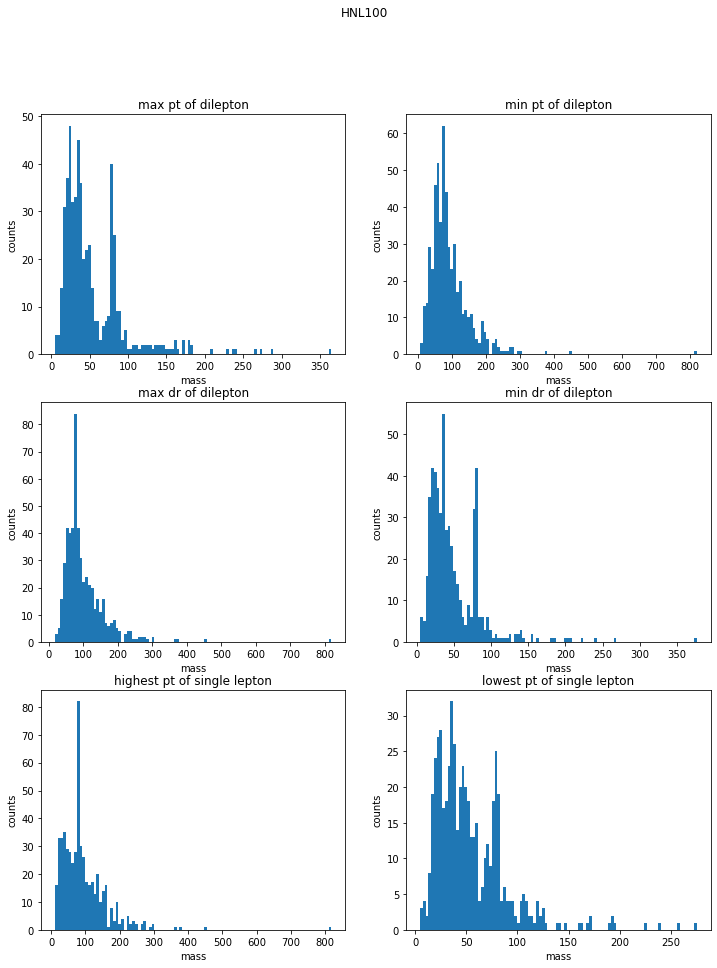

In [1]:
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from helpers import delta_r, delta_phi, inv_mass_3p, cos_opening_angle, inv_mass, delta_eta
from samples import signal_samples
from helpers import files_from_dir, files_from_dirs
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
local_dir = "C:\\Users\\lucas\\Desktop\\PDM\\data\\HeavyNeutrino_trilepton\\HeavyNeutrino_trilepton_M-100_V-0p01_tau_NLO_tauhFilter_TuneCP5_13TeV-madgraph-pythia8"
samples = files_from_dir(local_dir),
i_file = 1
tot_events = 0
overall_maxpt_mass = []
overall_minpt_mass = []
overall_mindr_mass = []
overall_maxdr_mass = []
overall_maxsolopt_mass = []
overall_minsolopt_mass = []
nb_HNL_minpt_all = 0
nb_HNL_maxpt_all = 0
nb_HNL_maxdr_all = 0
nb_HNL_mindr_all = 0
nb_HNL_solomin_all = 0
nb_HNL_solomax_all = 0


for file in samples[0]:
    events = NanoEventsFactory.from_root(file, schemaclass=NanoAODSchema).events()
    print(str(i_file)+"/"+str(len(samples[0])))
    i_file = i_file+1
    nb_events = len(events)
    tot_events = tot_events+nb_events
    events['weight'] = events.genWeight
    events['SelElectron'] = events.Electron[(events.Electron.pt > 20.) & (events.Electron.mvaFall17V2Iso_WP90 > 0.5)]
    events['SelMuon'] = events.Muon[(events.Muon.pt > 24.) & (events.Muon.mediumPromptId) & (events.Muon.pfRelIso03_all < 0.2) & (np.abs(events.Muon.dxy) < 0.005)]
    muon1, electron1 = ak.unzip(ak.cartesian([events.SelMuon, events.SelElectron], nested=True))
    match1 = ak.any(muon1.jetIdx == electron1.jetIdx, axis=-1, mask_identity=False)
    events['SelMuon'] = events.SelMuon[(~(match1))]  
    events['SelTau'] = events.Tau[(events.Tau.pt > 20.) & (events.Tau.idDeepTau2017v2p1VSmu > 0.5) & (events.Tau.idDeepTau2017v2p1VSe > 0.5) & (events.Tau.idDeepTau2017v2p1VSjet >=8)]
    tau2, electron2 = ak.unzip(ak.cartesian([events.SelTau, events.SelElectron], nested=True))
    match2 = ak.any(tau2.jetIdx == electron2.jetIdx, axis=-1, mask_identity=False)
    tau3, electron3 = ak.unzip(ak.cartesian([events.SelTau, events.SelElectron], nested=True))
    match3 = ak.any(tau3.jetIdx == electron3.jetIdx, axis=-1, mask_identity=False)
    events['SelTau'] = events.SelTau[((~(match2) & ~(match3)) )]
    events['SelTau'] = events.SelTau[events.SelTau.genPartIdx < 8]


    events = events[ak.num(events.SelElectron)+ak.num(events.SelMuon) + ak.num(events.SelTau) == 3]
    leptons = ak.concatenate([events.SelElectron, events.SelMuon,events.SelTau], axis = -1)
 
    parents = ak.concatenate([events.GenPart[events.SelElectron.genPartIdx].distinctParent.pdgId,events.GenPart[events.SelMuon.genPartIdx].distinctParent.pdgId,events.GenVisTau.parent.distinctParent.pdgId[events.SelTau.genPartIdx]], axis = -1)
    by1 = np.ones(len(leptons), np.int8)
    l1 = ak.unflatten(leptons[:,0],by1)
    l2 = ak.unflatten(leptons[:,1],by1)
    l3 = ak.unflatten(leptons[:,2],by1)
    p1 = ak.unflatten(parents[:,0],by1)
    p2 = ak.unflatten(parents[:,1],by1)
    p3 = ak.unflatten(parents[:,2],by1)

    pair1 = ak.concatenate([l1, l2], axis = -1)
    pair2 = ak.concatenate([l1, l3], axis = -1)
    pair3 = ak.concatenate([l3, l2], axis = -1)
    parent_pair1 = ak.concatenate([p1, p2], axis = -1)
    parent_pair2 = ak.concatenate([p1, p3], axis = -1)
    parent_pair3 = ak.concatenate([p3, p2], axis = -1)

    pairs = ak.concatenate([pair1, pair2, pair3], axis = 1)
    pairs = ak.flatten(pairs)
    by2 = np.full(int(len(pairs)/2), 2,np.int8 )
    pairs = ak.unflatten(pairs,by2)
    by3 = np.full(int(len(pairs)/3), 3 ,np.int8)
    pairs = ak.unflatten(pairs, by3)
    parent_pairs = ak.concatenate([parent_pair1, parent_pair2, parent_pair3], axis = 1)
    parent_pairs = ak.flatten(parent_pairs)
    by2 = np.full(int(len(parent_pairs)/2), 2,np.int8 )
    parent_pairs = ak.unflatten(parent_pairs,by2)
    by3 = np.full(int(len(parent_pairs)/3), 3 ,np.int8)
    parent_pairs = ak.unflatten(parent_pairs, by3)

    pairs_temp = pairs
    pairs = pairs[pairs[:,:,0].charge + pairs[:,:,1].charge == 0]
    pairs = pairs[ak.num(pairs) == 2]
    parent_pairs = parent_pairs[pairs_temp[:,:,0].charge + pairs_temp[:,:,1].charge == 0]
    parent_pairs = parent_pairs[ak.num(parent_pairs) == 2]

    #combined tranverse momentum, take maximum
    pairs_maxpt1 = pairs[(pairs[:,0,1]+pairs[:,0,0]).pt <  (pairs[:,:,0]+pairs[:,:,1]).pt ]
    pairs_maxpt1 = ak.flatten(pairs_maxpt1, axis = -1)
    pairs_maxpt2 = pairs[(pairs[:,1,1]+pairs[:,1,0]).pt <  (pairs[:,:,0]+pairs[:,:,1]).pt ]
    pairs_maxpt2 = ak.flatten(pairs_maxpt2, axis = -1)
    pairs_maxpt = ak.concatenate([pairs_maxpt1,pairs_maxpt2], axis = -1)
    pairs_maxpt_mass = (pairs_maxpt[:,0] + pairs_maxpt[:,1]).mass
    overall_maxpt_mass.extend(pairs_maxpt_mass)
    
    parent_pairs_maxpt1 = parent_pairs[(pairs[:,0,1]+pairs[:,0,0]).pt <  (pairs[:,:,0]+pairs[:,:,1]).pt ]
    parent_pairs_maxpt1 = ak.flatten(parent_pairs_maxpt1, axis = -1)
    parent_pairs_maxpt2 = parent_pairs[(pairs[:,1,1]+pairs[:,1,0]).pt <  (pairs[:,:,0]+pairs[:,:,1]).pt ]
    parent_pairs_maxpt2 = ak.flatten(parent_pairs_maxpt2, axis = -1)
    parent_pairs_maxpt = ak.concatenate([parent_pairs_maxpt1,parent_pairs_maxpt2], axis = -1)
    tot_pairs_maxpt = len(parent_pairs_maxpt)
    
    HNL_couple_maxpt = parent_pairs_maxpt[ak.any(abs(parent_pairs_maxpt) == 24, axis = -1)]
    HNL_couple_maxpt = HNL_couple_maxpt[ak.any(abs(HNL_couple_maxpt) == 9900012, axis = -1)]
    nb_HNL_maxpt = len(HNL_couple_maxpt)
    nb_HNL_maxpt_all = nb_HNL_maxpt_all + nb_HNL_maxpt

    
    #combined tranverse momentum, take minimum
    pairs_minpt1 = pairs[(pairs[:,0,1]+pairs[:,0,0]).pt >  (pairs[:,:,0]+pairs[:,:,1]).pt ]
    pairs_minpt1 = ak.flatten(pairs_minpt1, axis = -1)
    pairs_minpt2 = pairs[(pairs[:,1,1]+pairs[:,1,0]).pt >  (pairs[:,:,0]+pairs[:,:,1]).pt ]
    pairs_minpt2 = ak.flatten(pairs_minpt2, axis = -1)
    pairs_minpt = ak.concatenate([pairs_minpt1,pairs_minpt2], axis = -1)
    pairs_minpt_mass = (pairs_minpt[:,0] + pairs_minpt[:,1]).mass
    overall_minpt_mass.extend(pairs_minpt_mass)

    parent_pairs_minpt1 = parent_pairs[(pairs[:,0,1]+pairs[:,0,0]).pt >  (pairs[:,:,0]+pairs[:,:,1]).pt ]
    parent_pairs_minpt1 = ak.flatten(parent_pairs_minpt1, axis = -1)
    parent_pairs_minpt2 = parent_pairs[(pairs[:,1,1]+pairs[:,1,0]).pt >  (pairs[:,:,0]+pairs[:,:,1]).pt ]
    parent_pairs_minpt2 = ak.flatten(parent_pairs_minpt2, axis = -1)
    parent_pairs_minpt = ak.concatenate([parent_pairs_minpt1,parent_pairs_minpt2], axis = -1)
    tot_pairs_minpt = len(parent_pairs_minpt)
    HNL_couple_minpt = parent_pairs_minpt[ak.any(abs(parent_pairs_minpt) == 24, axis = -1)]
    HNL_couple_minpt = HNL_couple_minpt[ak.any(abs(HNL_couple_minpt) == 9900012, axis = -1)]
    nb_HNL_minpt = len(HNL_couple_minpt)
    nb_HNL_minpt_all = nb_HNL_minpt_all + nb_HNL_minpt
    

    #combined dr, take minimum
    pairs_mindr1 = pairs[delta_r(pairs[:,0,1],pairs[:,0,0]) >  delta_r(pairs[:,:,0],pairs[:,:,1]) ]
    pairs_mindr1 = ak.flatten(pairs_mindr1, axis = -1)
    pairs_mindr2 = pairs[delta_r(pairs[:,1,1],pairs[:,1,0]) >  delta_r(pairs[:,:,0],pairs[:,:,1]) ]
    pairs_mindr2 = ak.flatten(pairs_mindr2, axis = -1)
    pairs_mindr = ak.concatenate([pairs_mindr1,pairs_mindr2], axis = -1)
    pairs_mindr_mass = (pairs_mindr[:,0] + pairs_mindr[:,1]).mass
    overall_mindr_mass.extend(pairs_mindr_mass)

    parent_pairs_mindr1 = parent_pairs[delta_r(pairs[:,0,1],pairs[:,0,0]) >  delta_r(pairs[:,:,0],pairs[:,:,1]) ]
    parent_pairs_mindr1 = ak.flatten(parent_pairs_mindr1, axis = -1)
    parent_pairs_mindr2 =parent_pairs[delta_r(pairs[:,1,1],pairs[:,1,0]) >  delta_r(pairs[:,:,0],pairs[:,:,1]) ]
    parent_pairs_mindr2 = ak.flatten(parent_pairs_mindr2, axis = -1)
    parent_pairs_mindr = ak.concatenate([parent_pairs_mindr1,parent_pairs_mindr2], axis = -1)
    tot_pairs_mindr = len(parent_pairs_mindr)
    HNL_couple_mindr = parent_pairs_mindr[ak.any(abs(parent_pairs_mindr) == 24, axis = -1)]
    HNL_couple_mindr = HNL_couple_mindr[ak.any(abs(HNL_couple_mindr) == 9900012, axis = -1)]
    nb_HNL_mindr = len(HNL_couple_mindr)
    nb_HNL_mindr_all = nb_HNL_mindr_all + nb_HNL_mindr

    #combined dr, take maximum
    pairs_maxdr1 = pairs[delta_r(pairs[:,0,1],pairs[:,0,0]) <  delta_r(pairs[:,:,0],pairs[:,:,1]) ]
    pairs_maxdr1 = ak.flatten(pairs_maxdr1, axis = -1)
    pairs_maxdr2 = pairs[delta_r(pairs[:,1,1],pairs[:,1,0]) <  delta_r(pairs[:,:,0],pairs[:,:,1]) ]
    pairs_maxdr2 = ak.flatten(pairs_maxdr2, axis = -1)
    pairs_maxdr = ak.concatenate([pairs_maxdr1,pairs_maxdr2], axis = -1)
    pairs_maxdr_mass = (pairs_maxdr[:,0] + pairs_maxdr[:,1]).mass
    overall_maxdr_mass.extend(pairs_maxdr_mass)
    parent_pairs_maxdr1 = parent_pairs[delta_r(pairs[:,0,1],pairs[:,0,0]) <  delta_r(pairs[:,:,0],pairs[:,:,1]) ]
    parent_pairs_maxdr1 = ak.flatten(parent_pairs_maxdr1, axis = -1)
    parent_pairs_maxdr2 =parent_pairs[delta_r(pairs[:,1,1],pairs[:,1,0]) <  delta_r(pairs[:,:,0],pairs[:,:,1]) ]
    parent_pairs_maxdr2 = ak.flatten(parent_pairs_maxdr2, axis = -1)
    parent_pairs_maxdr = ak.concatenate([parent_pairs_maxdr1,parent_pairs_maxdr2], axis = -1)
    tot_pairs_maxdr = len(parent_pairs_maxdr)
    HNL_couple_maxdr = parent_pairs_maxdr[ak.any(abs(parent_pairs_maxdr) == 24, axis = -1)]
    HNL_couple_maxdr = HNL_couple_maxdr[ak.any(abs(HNL_couple_maxdr) == 9900012, axis = -1)]
    nb_HNL_maxdr = len(HNL_couple_maxdr)
    nb_HNL_maxdr_all = nb_HNL_maxdr_all + nb_HNL_maxdr





    #sum of tranverse momentum, take maximum ( same as taking the pair with highest single momentum)
    pairs_maxsolopt1 = pairs[pairs[:,0,1].pt+pairs[:,0,0].pt <  pairs[:,:,0].pt+pairs[:,:,1].pt ]
    pairs_maxsolopt1 = ak.flatten(pairs_maxsolopt1, axis = -1)
    pairs_maxsolopt2 = pairs[pairs[:,1,1].pt+pairs[:,1,0].pt <  pairs[:,:,0].pt+pairs[:,:,1].pt ]
    pairs_maxsolopt2 = ak.flatten(pairs_maxsolopt2, axis = -1)
    pairs_maxsolopt = ak.concatenate([pairs_maxsolopt1,pairs_maxsolopt2], axis = -1)
    pairs_maxsolopt_mass = (pairs_maxsolopt[:,0] + pairs_maxsolopt[:,1]).mass
    overall_maxsolopt_mass.extend(pairs_maxsolopt_mass)

    parent_pairs_maxsolopt1 = parent_pairs[pairs[:,0,1].pt+pairs[:,0,0].pt <  pairs[:,:,0].pt+pairs[:,:,1].pt]
    parent_pairs_maxsolopt1 = ak.flatten(parent_pairs_maxsolopt1, axis = -1)
    parent_pairs_maxsolopt2 =parent_pairs[pairs[:,1,1].pt+pairs[:,1,0].pt <  pairs[:,:,0].pt+pairs[:,:,1].pt  ]
    parent_pairs_maxsolopt2 = ak.flatten(parent_pairs_maxsolopt2, axis = -1)
    parent_pairs_maxsolopt = ak.concatenate([parent_pairs_maxsolopt1,parent_pairs_maxsolopt2], axis = -1)
    tot_pairs_maxsolopt = len(parent_pairs_maxsolopt)
    HNL_couple_maxsolopt = parent_pairs_maxsolopt[ak.any(abs(parent_pairs_maxsolopt) == 24, axis = -1)]
    HNL_couple_maxsolopt = HNL_couple_maxsolopt[ak.any(abs(HNL_couple_maxsolopt) == 9900012, axis = -1)]
    nb_HNL_maxsolopt = len(HNL_couple_maxsolopt)
    nb_HNL_solomax_all = nb_HNL_solomax_all + nb_HNL_maxsolopt


    #sum of tranverse momentum, take minimum ( same as taking the pair with lowest single momentum)
    pairs_minsolopt1 = pairs[pairs[:,0,1].pt+pairs[:,0,0].pt >  pairs[:,:,0].pt+pairs[:,:,1].pt ]
    pairs_minsolopt1 = ak.flatten(pairs_minsolopt1, axis = -1)
    pairs_minsolopt2 = pairs[pairs[:,1,1].pt+pairs[:,1,0].pt >  pairs[:,:,0].pt+pairs[:,:,1].pt ]
    pairs_minsolopt2 = ak.flatten(pairs_minsolopt2, axis = -1)
    pairs_minsolopt = ak.concatenate([pairs_minsolopt1,pairs_minsolopt2], axis = -1)
    pairs_minsolopt_mass = (pairs_minsolopt[:,0] + pairs_minsolopt[:,1]).mass
    overall_minsolopt_mass.extend(pairs_minsolopt_mass)

    parent_pairs_minsolopt1 = parent_pairs[pairs[:,0,1].pt+pairs[:,0,0].pt >  pairs[:,:,0].pt+pairs[:,:,1].pt]
    parent_pairs_minsolopt1 = ak.flatten(parent_pairs_minsolopt1, axis = -1)
    parent_pairs_minsolopt2 =parent_pairs[pairs[:,1,1].pt+pairs[:,1,0].pt >  pairs[:,:,0].pt+pairs[:,:,1].pt  ]
    parent_pairs_minsolopt2 = ak.flatten(parent_pairs_minsolopt2, axis = -1)
    parent_pairs_minsolopt = ak.concatenate([parent_pairs_minsolopt1,parent_pairs_minsolopt2], axis = -1)
    tot_pairs_minsolopt = len(parent_pairs_minsolopt)
    HNL_couple_minsolopt = parent_pairs_minsolopt[ak.any(abs(parent_pairs_minsolopt) == 24, axis = -1)]
    HNL_couple_minsolopt = HNL_couple_minsolopt[ak.any(abs(HNL_couple_minsolopt) == 9900012, axis = -1)]
    nb_HNL_minsolopt = len(HNL_couple_minsolopt)
    nb_HNL_solomin_all = nb_HNL_solomin_all + nb_HNL_minsolopt




print("ratio of HNL dilepton lowest pt/highest pt: " + str(nb_HNL_minpt_all) +"/"+ str(nb_HNL_maxpt_all) + " = " + str(100*nb_HNL_minpt_all/(nb_HNL_minpt_all + nb_HNL_maxpt_all))+"/" + str(100*nb_HNL_maxpt_all/(nb_HNL_minpt_all + nb_HNL_maxpt_all)))
print("ratio of HNL dilepton lowest dr/highest dr: " + str(nb_HNL_mindr_all) +"/"+ str(nb_HNL_maxdr_all) + " = " + str(100*nb_HNL_mindr_all/(nb_HNL_mindr_all + nb_HNL_maxdr_all))+"/" + str(100*nb_HNL_maxdr_all/(nb_HNL_mindr_all + nb_HNL_maxdr_all)))
print("ratio of HNL dilepton single lowest pt/highest pz: " + str(nb_HNL_solomin_all) +"/"+ str(nb_HNL_solomax_all) + " = " + str(100*nb_HNL_solomin_all/(nb_HNL_solomin_all + nb_HNL_solomax_all))+"/" + str(100*nb_HNL_solomax_all/(nb_HNL_solomin_all + nb_HNL_solomax_all)))

nbins = 100
plt.figure(figsize=(12,15))
plt.suptitle("HNL100")
plt.subplot(3, 2, 1)
plt.hist(pairs_maxpt_mass, bins = nbins)
plt.title("max pt of dilepton")
plt.xlabel('mass')
plt.ylabel('counts')
plt.subplot(3, 2, 2)
plt.hist(pairs_minpt_mass, bins = nbins)
plt.title("min pt of dilepton")
plt.xlabel('mass')
plt.ylabel('counts')
plt.subplot(3, 2, 3)
plt.hist(pairs_maxdr_mass, bins = nbins)
plt.title("max dr of dilepton")
plt.xlabel('mass')
plt.ylabel('counts')
plt.subplot(3, 2, 4)
plt.hist(pairs_mindr_mass, bins = nbins)
plt.title("min dr of dilepton")
plt.xlabel('mass')
plt.ylabel('counts')
plt.subplot(3, 2, 5)
plt.hist(pairs_maxsolopt_mass, bins = nbins)
plt.title("highest pt of single lepton")
plt.xlabel('mass')
plt.ylabel('counts')
plt.subplot(3, 2, 6)
plt.hist(pairs_minsolopt_mass, bins = nbins)
plt.title("lowest pt of single lepton")
plt.xlabel('mass')
plt.ylabel('counts')
plt.savefig('HNL100_mass_which.pdf')  

plt.show()

    

1/1
ratio of HNL dilepton lowest pt/highest pt: 6003/6741 = 47.1045197740113/52.8954802259887
ratio of HNL dilepton lowest dr/highest dr: 8131/7907 = 50.69834143908218/49.30165856091782
ratio of HNL dilepton single lowest pt/highest pz: 6020/6724 = 47.23791588198368/52.76208411801632


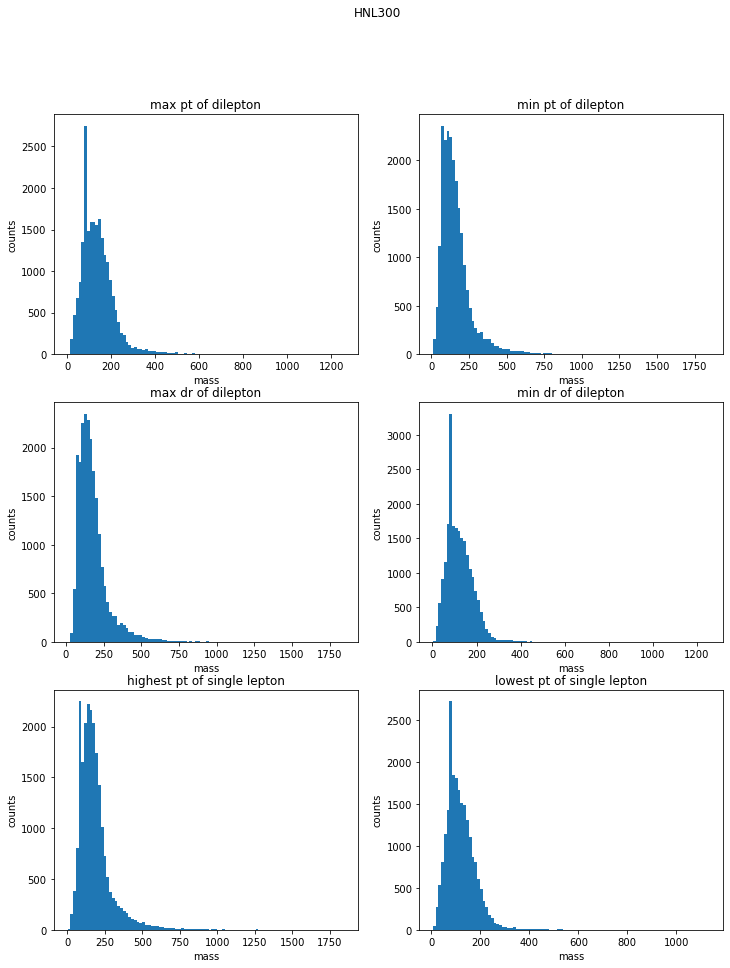

In [2]:
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from helpers import delta_r, delta_phi, inv_mass_3p, cos_opening_angle, inv_mass, delta_eta
from samples import signal_samples
from helpers import files_from_dir, files_from_dirs
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
local_dir = "C:\\Users\\lucas\\Desktop\\PDM\\data\\HeavyNeutrino_trilepton\\HeavyNeutrino_trilepton_M-300_V-0p01_tau_NLO_tauhFilter_TuneCP5_13TeV-madgraph-pythia8"
samples = files_from_dir(local_dir),
i_file = 1
tot_events = 0
overall_maxpt_mass = []
overall_minpt_mass = []
overall_mindr_mass = []
overall_maxdr_mass = []
overall_maxsolopt_mass = []
overall_minsolopt_mass = []
nb_HNL_minpt_all = 0
nb_HNL_maxpt_all = 0
nb_HNL_maxdr_all = 0
nb_HNL_mindr_all = 0
nb_HNL_solomin_all = 0
nb_HNL_solomax_all = 0


for file in samples[0]:
    events = NanoEventsFactory.from_root(file, schemaclass=NanoAODSchema).events()
    print(str(i_file)+"/"+str(len(samples[0])))
    i_file = i_file+1
    nb_events = len(events)
    tot_events = tot_events+nb_events
    events['weight'] = events.genWeight
    events['SelElectron'] = events.Electron[(events.Electron.pt > 20.) & (events.Electron.mvaFall17V2Iso_WP90 > 0.5)]
    events['SelMuon'] = events.Muon[(events.Muon.pt > 24.) & (events.Muon.mediumPromptId) & (events.Muon.pfRelIso03_all < 0.2) & (np.abs(events.Muon.dxy) < 0.005)]
    muon1, electron1 = ak.unzip(ak.cartesian([events.SelMuon, events.SelElectron], nested=True))
    match1 = ak.any(muon1.jetIdx == electron1.jetIdx, axis=-1, mask_identity=False)
    events['SelMuon'] = events.SelMuon[(~(match1))]  
    events['SelTau'] = events.Tau[(events.Tau.pt > 20.) & (events.Tau.idDeepTau2017v2p1VSmu > 0.5) & (events.Tau.idDeepTau2017v2p1VSe > 0.5) & (events.Tau.idDeepTau2017v2p1VSjet >=8)]
    tau2, electron2 = ak.unzip(ak.cartesian([events.SelTau, events.SelElectron], nested=True))
    match2 = ak.any(tau2.jetIdx == electron2.jetIdx, axis=-1, mask_identity=False)
    tau3, electron3 = ak.unzip(ak.cartesian([events.SelTau, events.SelElectron], nested=True))
    match3 = ak.any(tau3.jetIdx == electron3.jetIdx, axis=-1, mask_identity=False)
    events['SelTau'] = events.SelTau[((~(match2) & ~(match3)) )]
    events['SelTau'] = events.SelTau[events.SelTau.genPartIdx < 8]


    events = events[ak.num(events.SelElectron)+ak.num(events.SelMuon) + ak.num(events.SelTau) == 3]
    leptons = ak.concatenate([events.SelElectron, events.SelMuon,events.SelTau], axis = -1)
 
    parents = ak.concatenate([events.GenPart[events.SelElectron.genPartIdx].distinctParent.pdgId,events.GenPart[events.SelMuon.genPartIdx].distinctParent.pdgId,events.GenVisTau.parent.distinctParent.pdgId[events.SelTau.genPartIdx]], axis = -1)
    by1 = np.ones(len(leptons), np.int8)
    l1 = ak.unflatten(leptons[:,0],by1)
    l2 = ak.unflatten(leptons[:,1],by1)
    l3 = ak.unflatten(leptons[:,2],by1)
    p1 = ak.unflatten(parents[:,0],by1)
    p2 = ak.unflatten(parents[:,1],by1)
    p3 = ak.unflatten(parents[:,2],by1)

    pair1 = ak.concatenate([l1, l2], axis = -1)
    pair2 = ak.concatenate([l1, l3], axis = -1)
    pair3 = ak.concatenate([l3, l2], axis = -1)
    parent_pair1 = ak.concatenate([p1, p2], axis = -1)
    parent_pair2 = ak.concatenate([p1, p3], axis = -1)
    parent_pair3 = ak.concatenate([p3, p2], axis = -1)

    pairs = ak.concatenate([pair1, pair2, pair3], axis = 1)
    pairs = ak.flatten(pairs)
    by2 = np.full(int(len(pairs)/2), 2,np.int8 )
    pairs = ak.unflatten(pairs,by2)
    by3 = np.full(int(len(pairs)/3), 3 ,np.int8)
    pairs = ak.unflatten(pairs, by3)
    parent_pairs = ak.concatenate([parent_pair1, parent_pair2, parent_pair3], axis = 1)
    parent_pairs = ak.flatten(parent_pairs)
    by2 = np.full(int(len(parent_pairs)/2), 2,np.int8 )
    parent_pairs = ak.unflatten(parent_pairs,by2)
    by3 = np.full(int(len(parent_pairs)/3), 3 ,np.int8)
    parent_pairs = ak.unflatten(parent_pairs, by3)

    pairs_temp = pairs
    pairs = pairs[pairs[:,:,0].charge + pairs[:,:,1].charge == 0]
    pairs = pairs[ak.num(pairs) == 2]
    parent_pairs = parent_pairs[pairs_temp[:,:,0].charge + pairs_temp[:,:,1].charge == 0]
    parent_pairs = parent_pairs[ak.num(parent_pairs) == 2]

    #combined tranverse momentum, take maximum
    pairs_maxpt1 = pairs[(pairs[:,0,1]+pairs[:,0,0]).pt <  (pairs[:,:,0]+pairs[:,:,1]).pt ]
    pairs_maxpt1 = ak.flatten(pairs_maxpt1, axis = -1)
    pairs_maxpt2 = pairs[(pairs[:,1,1]+pairs[:,1,0]).pt <  (pairs[:,:,0]+pairs[:,:,1]).pt ]
    pairs_maxpt2 = ak.flatten(pairs_maxpt2, axis = -1)
    pairs_maxpt = ak.concatenate([pairs_maxpt1,pairs_maxpt2], axis = -1)
    pairs_maxpt_mass = (pairs_maxpt[:,0] + pairs_maxpt[:,1]).mass
    overall_maxpt_mass.extend(pairs_maxpt_mass)
    
    parent_pairs_maxpt1 = parent_pairs[(pairs[:,0,1]+pairs[:,0,0]).pt <  (pairs[:,:,0]+pairs[:,:,1]).pt ]
    parent_pairs_maxpt1 = ak.flatten(parent_pairs_maxpt1, axis = -1)
    parent_pairs_maxpt2 = parent_pairs[(pairs[:,1,1]+pairs[:,1,0]).pt <  (pairs[:,:,0]+pairs[:,:,1]).pt ]
    parent_pairs_maxpt2 = ak.flatten(parent_pairs_maxpt2, axis = -1)
    parent_pairs_maxpt = ak.concatenate([parent_pairs_maxpt1,parent_pairs_maxpt2], axis = -1)
    tot_pairs_maxpt = len(parent_pairs_maxpt)
    
    HNL_couple_maxpt = parent_pairs_maxpt[ak.any(abs(parent_pairs_maxpt) == 24, axis = -1)]
    HNL_couple_maxpt = HNL_couple_maxpt[ak.any(abs(HNL_couple_maxpt) == 9900012, axis = -1)]
    nb_HNL_maxpt = len(HNL_couple_maxpt)
    nb_HNL_maxpt_all = nb_HNL_maxpt_all + nb_HNL_maxpt

    
    #combined tranverse momentum, take minimum
    pairs_minpt1 = pairs[(pairs[:,0,1]+pairs[:,0,0]).pt >  (pairs[:,:,0]+pairs[:,:,1]).pt ]
    pairs_minpt1 = ak.flatten(pairs_minpt1, axis = -1)
    pairs_minpt2 = pairs[(pairs[:,1,1]+pairs[:,1,0]).pt >  (pairs[:,:,0]+pairs[:,:,1]).pt ]
    pairs_minpt2 = ak.flatten(pairs_minpt2, axis = -1)
    pairs_minpt = ak.concatenate([pairs_minpt1,pairs_minpt2], axis = -1)
    pairs_minpt_mass = (pairs_minpt[:,0] + pairs_minpt[:,1]).mass
    overall_minpt_mass.extend(pairs_minpt_mass)

    parent_pairs_minpt1 = parent_pairs[(pairs[:,0,1]+pairs[:,0,0]).pt >  (pairs[:,:,0]+pairs[:,:,1]).pt ]
    parent_pairs_minpt1 = ak.flatten(parent_pairs_minpt1, axis = -1)
    parent_pairs_minpt2 = parent_pairs[(pairs[:,1,1]+pairs[:,1,0]).pt >  (pairs[:,:,0]+pairs[:,:,1]).pt ]
    parent_pairs_minpt2 = ak.flatten(parent_pairs_minpt2, axis = -1)
    parent_pairs_minpt = ak.concatenate([parent_pairs_minpt1,parent_pairs_minpt2], axis = -1)
    tot_pairs_minpt = len(parent_pairs_minpt)
    HNL_couple_minpt = parent_pairs_minpt[ak.any(abs(parent_pairs_minpt) == 24, axis = -1)]
    HNL_couple_minpt = HNL_couple_minpt[ak.any(abs(HNL_couple_minpt) == 9900012, axis = -1)]
    nb_HNL_minpt = len(HNL_couple_minpt)
    nb_HNL_minpt_all = nb_HNL_minpt_all + nb_HNL_minpt
    

    #combined dr, take minimum
    pairs_mindr1 = pairs[delta_r(pairs[:,0,1],pairs[:,0,0]) >  delta_r(pairs[:,:,0],pairs[:,:,1]) ]
    pairs_mindr1 = ak.flatten(pairs_mindr1, axis = -1)
    pairs_mindr2 = pairs[delta_r(pairs[:,1,1],pairs[:,1,0]) >  delta_r(pairs[:,:,0],pairs[:,:,1]) ]
    pairs_mindr2 = ak.flatten(pairs_mindr2, axis = -1)
    pairs_mindr = ak.concatenate([pairs_mindr1,pairs_mindr2], axis = -1)
    pairs_mindr_mass = (pairs_mindr[:,0] + pairs_mindr[:,1]).mass
    overall_mindr_mass.extend(pairs_mindr_mass)

    parent_pairs_mindr1 = parent_pairs[delta_r(pairs[:,0,1],pairs[:,0,0]) >  delta_r(pairs[:,:,0],pairs[:,:,1]) ]
    parent_pairs_mindr1 = ak.flatten(parent_pairs_mindr1, axis = -1)
    parent_pairs_mindr2 =parent_pairs[delta_r(pairs[:,1,1],pairs[:,1,0]) >  delta_r(pairs[:,:,0],pairs[:,:,1]) ]
    parent_pairs_mindr2 = ak.flatten(parent_pairs_mindr2, axis = -1)
    parent_pairs_mindr = ak.concatenate([parent_pairs_mindr1,parent_pairs_mindr2], axis = -1)
    tot_pairs_mindr = len(parent_pairs_mindr)
    HNL_couple_mindr = parent_pairs_mindr[ak.any(abs(parent_pairs_mindr) == 24, axis = -1)]
    HNL_couple_mindr = HNL_couple_mindr[ak.any(abs(HNL_couple_mindr) == 9900012, axis = -1)]
    nb_HNL_mindr = len(HNL_couple_mindr)
    nb_HNL_mindr_all = nb_HNL_mindr_all + nb_HNL_mindr

    #combined dr, take maximum
    pairs_maxdr1 = pairs[delta_r(pairs[:,0,1],pairs[:,0,0]) <  delta_r(pairs[:,:,0],pairs[:,:,1]) ]
    pairs_maxdr1 = ak.flatten(pairs_maxdr1, axis = -1)
    pairs_maxdr2 = pairs[delta_r(pairs[:,1,1],pairs[:,1,0]) <  delta_r(pairs[:,:,0],pairs[:,:,1]) ]
    pairs_maxdr2 = ak.flatten(pairs_maxdr2, axis = -1)
    pairs_maxdr = ak.concatenate([pairs_maxdr1,pairs_maxdr2], axis = -1)
    pairs_maxdr_mass = (pairs_maxdr[:,0] + pairs_maxdr[:,1]).mass
    overall_maxdr_mass.extend(pairs_maxdr_mass)
    parent_pairs_maxdr1 = parent_pairs[delta_r(pairs[:,0,1],pairs[:,0,0]) <  delta_r(pairs[:,:,0],pairs[:,:,1]) ]
    parent_pairs_maxdr1 = ak.flatten(parent_pairs_maxdr1, axis = -1)
    parent_pairs_maxdr2 =parent_pairs[delta_r(pairs[:,1,1],pairs[:,1,0]) <  delta_r(pairs[:,:,0],pairs[:,:,1]) ]
    parent_pairs_maxdr2 = ak.flatten(parent_pairs_maxdr2, axis = -1)
    parent_pairs_maxdr = ak.concatenate([parent_pairs_maxdr1,parent_pairs_maxdr2], axis = -1)
    tot_pairs_maxdr = len(parent_pairs_maxdr)
    HNL_couple_maxdr = parent_pairs_maxdr[ak.any(abs(parent_pairs_maxdr) == 24, axis = -1)]
    HNL_couple_maxdr = HNL_couple_maxdr[ak.any(abs(HNL_couple_maxdr) == 9900012, axis = -1)]
    nb_HNL_maxdr = len(HNL_couple_maxdr)
    nb_HNL_maxdr_all = nb_HNL_maxdr_all + nb_HNL_maxdr





    #sum of tranverse momentum, take maximum ( same as taking the pair with highest single momentum)
    pairs_maxsolopt1 = pairs[pairs[:,0,1].pt+pairs[:,0,0].pt <  pairs[:,:,0].pt+pairs[:,:,1].pt ]
    pairs_maxsolopt1 = ak.flatten(pairs_maxsolopt1, axis = -1)
    pairs_maxsolopt2 = pairs[pairs[:,1,1].pt+pairs[:,1,0].pt <  pairs[:,:,0].pt+pairs[:,:,1].pt ]
    pairs_maxsolopt2 = ak.flatten(pairs_maxsolopt2, axis = -1)
    pairs_maxsolopt = ak.concatenate([pairs_maxsolopt1,pairs_maxsolopt2], axis = -1)
    pairs_maxsolopt_mass = (pairs_maxsolopt[:,0] + pairs_maxsolopt[:,1]).mass
    overall_maxsolopt_mass.extend(pairs_maxsolopt_mass)

    parent_pairs_maxsolopt1 = parent_pairs[pairs[:,0,1].pt+pairs[:,0,0].pt <  pairs[:,:,0].pt+pairs[:,:,1].pt]
    parent_pairs_maxsolopt1 = ak.flatten(parent_pairs_maxsolopt1, axis = -1)
    parent_pairs_maxsolopt2 =parent_pairs[pairs[:,1,1].pt+pairs[:,1,0].pt <  pairs[:,:,0].pt+pairs[:,:,1].pt  ]
    parent_pairs_maxsolopt2 = ak.flatten(parent_pairs_maxsolopt2, axis = -1)
    parent_pairs_maxsolopt = ak.concatenate([parent_pairs_maxsolopt1,parent_pairs_maxsolopt2], axis = -1)
    tot_pairs_maxsolopt = len(parent_pairs_maxsolopt)
    HNL_couple_maxsolopt = parent_pairs_maxsolopt[ak.any(abs(parent_pairs_maxsolopt) == 24, axis = -1)]
    HNL_couple_maxsolopt = HNL_couple_maxsolopt[ak.any(abs(HNL_couple_maxsolopt) == 9900012, axis = -1)]
    nb_HNL_maxsolopt = len(HNL_couple_maxsolopt)
    nb_HNL_solomax_all = nb_HNL_solomax_all + nb_HNL_maxsolopt


    #sum of tranverse momentum, take minimum ( same as taking the pair with lowest single momentum)
    pairs_minsolopt1 = pairs[pairs[:,0,1].pt+pairs[:,0,0].pt >  pairs[:,:,0].pt+pairs[:,:,1].pt ]
    pairs_minsolopt1 = ak.flatten(pairs_minsolopt1, axis = -1)
    pairs_minsolopt2 = pairs[pairs[:,1,1].pt+pairs[:,1,0].pt >  pairs[:,:,0].pt+pairs[:,:,1].pt ]
    pairs_minsolopt2 = ak.flatten(pairs_minsolopt2, axis = -1)
    pairs_minsolopt = ak.concatenate([pairs_minsolopt1,pairs_minsolopt2], axis = -1)
    pairs_minsolopt_mass = (pairs_minsolopt[:,0] + pairs_minsolopt[:,1]).mass
    overall_minsolopt_mass.extend(pairs_minsolopt_mass)

    parent_pairs_minsolopt1 = parent_pairs[pairs[:,0,1].pt+pairs[:,0,0].pt >  pairs[:,:,0].pt+pairs[:,:,1].pt]
    parent_pairs_minsolopt1 = ak.flatten(parent_pairs_minsolopt1, axis = -1)
    parent_pairs_minsolopt2 =parent_pairs[pairs[:,1,1].pt+pairs[:,1,0].pt >  pairs[:,:,0].pt+pairs[:,:,1].pt  ]
    parent_pairs_minsolopt2 = ak.flatten(parent_pairs_minsolopt2, axis = -1)
    parent_pairs_minsolopt = ak.concatenate([parent_pairs_minsolopt1,parent_pairs_minsolopt2], axis = -1)
    tot_pairs_minsolopt = len(parent_pairs_minsolopt)
    HNL_couple_minsolopt = parent_pairs_minsolopt[ak.any(abs(parent_pairs_minsolopt) == 24, axis = -1)]
    HNL_couple_minsolopt = HNL_couple_minsolopt[ak.any(abs(HNL_couple_minsolopt) == 9900012, axis = -1)]
    nb_HNL_minsolopt = len(HNL_couple_minsolopt)
    nb_HNL_solomin_all = nb_HNL_solomin_all + nb_HNL_minsolopt




print("ratio of HNL dilepton lowest pt/highest pt: " + str(nb_HNL_minpt_all) +"/"+ str(nb_HNL_maxpt_all) + " = " + str(100*nb_HNL_minpt_all/(nb_HNL_minpt_all + nb_HNL_maxpt_all))+"/" + str(100*nb_HNL_maxpt_all/(nb_HNL_minpt_all + nb_HNL_maxpt_all)))
print("ratio of HNL dilepton lowest dr/highest dr: " + str(nb_HNL_mindr_all) +"/"+ str(nb_HNL_maxdr_all) + " = " + str(100*nb_HNL_mindr_all/(nb_HNL_mindr_all + nb_HNL_maxdr_all))+"/" + str(100*nb_HNL_maxdr_all/(nb_HNL_mindr_all + nb_HNL_maxdr_all)))
print("ratio of HNL dilepton single lowest pt/highest pz: " + str(nb_HNL_solomin_all) +"/"+ str(nb_HNL_solomax_all) + " = " + str(100*nb_HNL_solomin_all/(nb_HNL_solomin_all + nb_HNL_solomax_all))+"/" + str(100*nb_HNL_solomax_all/(nb_HNL_solomin_all + nb_HNL_solomax_all)))

nbins = 100
plt.figure(figsize=(12,15))
plt.suptitle("HNL300")
plt.subplot(3, 2, 1)
plt.hist(pairs_maxpt_mass, bins = nbins)
plt.title("max pt of dilepton")
plt.xlabel('mass')
plt.ylabel('counts')
plt.subplot(3, 2, 2)
plt.hist(pairs_minpt_mass, bins = nbins)
plt.title("min pt of dilepton")
plt.xlabel('mass')
plt.ylabel('counts')
plt.subplot(3, 2, 3)
plt.hist(pairs_maxdr_mass, bins = nbins)
plt.title("max dr of dilepton")
plt.xlabel('mass')
plt.ylabel('counts')
plt.subplot(3, 2, 4)
plt.hist(pairs_mindr_mass, bins = nbins)
plt.title("min dr of dilepton")
plt.xlabel('mass')
plt.ylabel('counts')
plt.subplot(3, 2, 5)
plt.hist(pairs_maxsolopt_mass, bins = nbins)
plt.title("highest pt of single lepton")
plt.xlabel('mass')
plt.ylabel('counts')
plt.subplot(3, 2, 6)
plt.hist(pairs_minsolopt_mass, bins = nbins)
plt.title("lowest pt of single lepton")
plt.xlabel('mass')
plt.ylabel('counts')
plt.savefig('HNL300_mass_which.pdf')  

plt.show()

    

C:\Users\lucas\Desktop\PDM\data\HeavyNeutrino_trilepton\HeavyNeutrino_trilepton_M-1000_V-0p01_tau_NLO_tauhFilter_TuneCP5_13TeV-madgraph-pythia8/04A432CC-4CBC-694C-A85F-3322CFD467D5.root
1/8
C:\Users\lucas\Desktop\PDM\data\HeavyNeutrino_trilepton\HeavyNeutrino_trilepton_M-1000_V-0p01_tau_NLO_tauhFilter_TuneCP5_13TeV-madgraph-pythia8/4E52738F-3CCC-E142-A550-A29DAF4E7606.root
2/8
C:\Users\lucas\Desktop\PDM\data\HeavyNeutrino_trilepton\HeavyNeutrino_trilepton_M-1000_V-0p01_tau_NLO_tauhFilter_TuneCP5_13TeV-madgraph-pythia8/6536D59C-10D5-EF4D-B980-A894DDC8C424.root
3/8
C:\Users\lucas\Desktop\PDM\data\HeavyNeutrino_trilepton\HeavyNeutrino_trilepton_M-1000_V-0p01_tau_NLO_tauhFilter_TuneCP5_13TeV-madgraph-pythia8/9B409DA6-46C9-D646-8E72-DDD6034A301E.root
4/8
C:\Users\lucas\Desktop\PDM\data\HeavyNeutrino_trilepton\HeavyNeutrino_trilepton_M-1000_V-0p01_tau_NLO_tauhFilter_TuneCP5_13TeV-madgraph-pythia8/A7B0C5A7-4D88-334F-BF1E-E84D77676E51.root
5/8
C:\Users\lucas\Desktop\PDM\data\HeavyNeutrino_tril

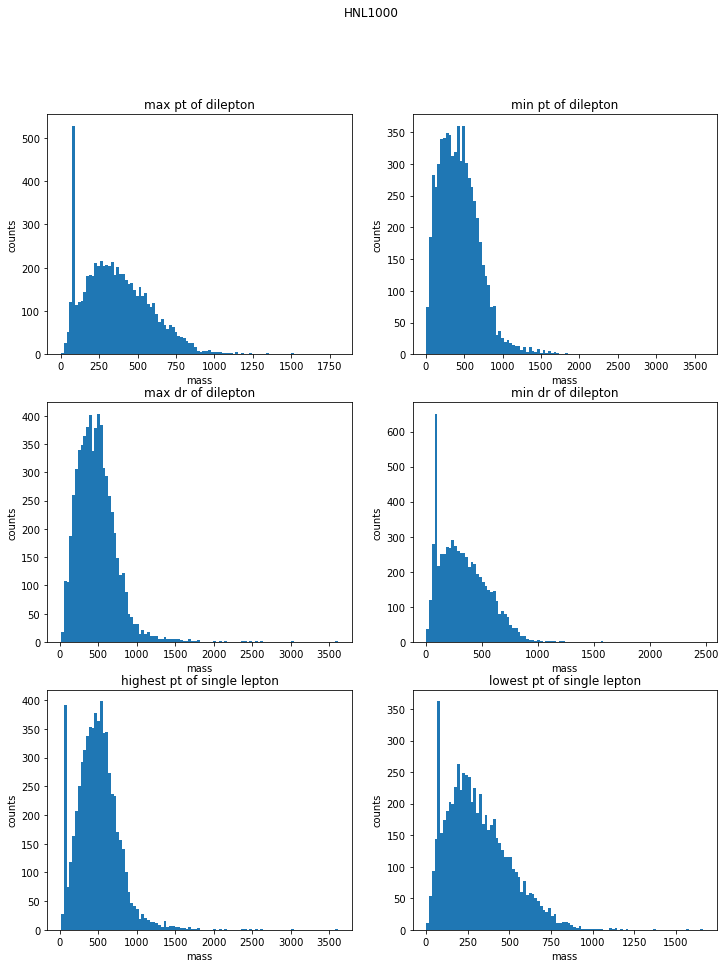

In [1]:
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from helpers import delta_r, delta_phi, inv_mass_3p, cos_opening_angle, inv_mass, delta_eta
from samples import signal_samples
from helpers import files_from_dir, files_from_dirs
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
local_dir = "C:\\Users\\lucas\\Desktop\\PDM\\data\\HeavyNeutrino_trilepton\\HeavyNeutrino_trilepton_M-1000_V-0p01_tau_NLO_tauhFilter_TuneCP5_13TeV-madgraph-pythia8"
samples = files_from_dir(local_dir),
i_file = 1
tot_events = 0
overall_maxpt_mass = []
overall_minpt_mass = []
overall_mindr_mass = []
overall_maxdr_mass = []
overall_maxsolopt_mass = []
overall_minsolopt_mass = []
nb_HNL_minpt_all = 0
nb_HNL_maxpt_all = 0
nb_HNL_maxdr_all = 0
nb_HNL_mindr_all = 0
nb_HNL_solomin_all = 0
nb_HNL_solomax_all = 0


for file in samples[0]:
    print(file)
    events = NanoEventsFactory.from_root(file, schemaclass=NanoAODSchema).events()
    print(str(i_file)+"/"+str(len(samples[0])))
    i_file = i_file+1
    nb_events = len(events)
    tot_events = tot_events+nb_events
    events['weight'] = events.genWeight
    events['SelElectron'] = events.Electron[(events.Electron.pt > 20.) & (events.Electron.mvaFall17V2Iso_WP90 > 0.5)]
    events['SelMuon'] = events.Muon[(events.Muon.pt > 24.) & (events.Muon.mediumPromptId) & (events.Muon.pfRelIso03_all < 0.2) & (np.abs(events.Muon.dxy) < 0.005)]
    muon1, electron1 = ak.unzip(ak.cartesian([events.SelMuon, events.SelElectron], nested=True))
    match1 = ak.any(muon1.jetIdx == electron1.jetIdx, axis=-1, mask_identity=False)
    events['SelMuon'] = events.SelMuon[(~(match1))]  
    events['SelTau'] = events.Tau[(events.Tau.pt > 20.) & (events.Tau.idDeepTau2017v2p1VSmu > 0.5) & (events.Tau.idDeepTau2017v2p1VSe > 0.5) & (events.Tau.idDeepTau2017v2p1VSjet >=8)]
    tau2, electron2 = ak.unzip(ak.cartesian([events.SelTau, events.SelElectron], nested=True))
    match2 = ak.any(tau2.jetIdx == electron2.jetIdx, axis=-1, mask_identity=False)
    tau3, electron3 = ak.unzip(ak.cartesian([events.SelTau, events.SelElectron], nested=True))
    match3 = ak.any(tau3.jetIdx == electron3.jetIdx, axis=-1, mask_identity=False)
    events['SelTau'] = events.SelTau[((~(match2) & ~(match3)) )]
    events['SelTau'] = events.SelTau[events.SelTau.genPartIdx < 8]


    events = events[ak.num(events.SelElectron)+ak.num(events.SelMuon) + ak.num(events.SelTau) == 3]
    leptons = ak.concatenate([events.SelElectron, events.SelMuon,events.SelTau], axis = -1)
 
    parents = ak.concatenate([events.GenPart[events.SelElectron.genPartIdx].distinctParent.pdgId,events.GenPart[events.SelMuon.genPartIdx].distinctParent.pdgId,events.GenVisTau.parent.distinctParent.pdgId[events.SelTau.genPartIdx]], axis = -1)
    by1 = np.ones(len(leptons), np.int8)
    l1 = ak.unflatten(leptons[:,0],by1)
    l2 = ak.unflatten(leptons[:,1],by1)
    l3 = ak.unflatten(leptons[:,2],by1)
    p1 = ak.unflatten(parents[:,0],by1)
    p2 = ak.unflatten(parents[:,1],by1)
    p3 = ak.unflatten(parents[:,2],by1)

    pair1 = ak.concatenate([l1, l2], axis = -1)
    pair2 = ak.concatenate([l1, l3], axis = -1)
    pair3 = ak.concatenate([l3, l2], axis = -1)
    parent_pair1 = ak.concatenate([p1, p2], axis = -1)
    parent_pair2 = ak.concatenate([p1, p3], axis = -1)
    parent_pair3 = ak.concatenate([p3, p2], axis = -1)

    pairs = ak.concatenate([pair1, pair2, pair3], axis = 1)
    pairs = ak.flatten(pairs)
    by2 = np.full(int(len(pairs)/2), 2,np.int8 )
    pairs = ak.unflatten(pairs,by2)
    by3 = np.full(int(len(pairs)/3), 3 ,np.int8)
    pairs = ak.unflatten(pairs, by3)
    parent_pairs = ak.concatenate([parent_pair1, parent_pair2, parent_pair3], axis = 1)
    parent_pairs = ak.flatten(parent_pairs)
    by2 = np.full(int(len(parent_pairs)/2), 2,np.int8 )
    parent_pairs = ak.unflatten(parent_pairs,by2)
    by3 = np.full(int(len(parent_pairs)/3), 3 ,np.int8)
    parent_pairs = ak.unflatten(parent_pairs, by3)

    pairs_temp = pairs
    pairs = pairs[pairs[:,:,0].charge + pairs[:,:,1].charge == 0]
    pairs = pairs[ak.num(pairs) == 2]
    parent_pairs = parent_pairs[pairs_temp[:,:,0].charge + pairs_temp[:,:,1].charge == 0]
    parent_pairs = parent_pairs[ak.num(parent_pairs) == 2]

    #combined tranverse momentum, take maximum
    pairs_maxpt1 = pairs[(pairs[:,0,1]+pairs[:,0,0]).pt <  (pairs[:,:,0]+pairs[:,:,1]).pt ]
    pairs_maxpt1 = ak.flatten(pairs_maxpt1, axis = -1)
    pairs_maxpt2 = pairs[(pairs[:,1,1]+pairs[:,1,0]).pt <  (pairs[:,:,0]+pairs[:,:,1]).pt ]
    pairs_maxpt2 = ak.flatten(pairs_maxpt2, axis = -1)
    pairs_maxpt = ak.concatenate([pairs_maxpt1,pairs_maxpt2], axis = -1)
    pairs_maxpt_mass = (pairs_maxpt[:,0] + pairs_maxpt[:,1]).mass
    overall_maxpt_mass.extend(pairs_maxpt_mass)
    
    parent_pairs_maxpt1 = parent_pairs[(pairs[:,0,1]+pairs[:,0,0]).pt <  (pairs[:,:,0]+pairs[:,:,1]).pt ]
    parent_pairs_maxpt1 = ak.flatten(parent_pairs_maxpt1, axis = -1)
    parent_pairs_maxpt2 = parent_pairs[(pairs[:,1,1]+pairs[:,1,0]).pt <  (pairs[:,:,0]+pairs[:,:,1]).pt ]
    parent_pairs_maxpt2 = ak.flatten(parent_pairs_maxpt2, axis = -1)
    parent_pairs_maxpt = ak.concatenate([parent_pairs_maxpt1,parent_pairs_maxpt2], axis = -1)
    tot_pairs_maxpt = len(parent_pairs_maxpt)
    
    HNL_couple_maxpt = parent_pairs_maxpt[ak.any(abs(parent_pairs_maxpt) == 24, axis = -1)]
    HNL_couple_maxpt = HNL_couple_maxpt[ak.any(abs(HNL_couple_maxpt) == 9900012, axis = -1)]
    nb_HNL_maxpt = len(HNL_couple_maxpt)
    nb_HNL_maxpt_all = nb_HNL_maxpt_all + nb_HNL_maxpt

    
    #combined tranverse momentum, take minimum
    pairs_minpt1 = pairs[(pairs[:,0,1]+pairs[:,0,0]).pt >  (pairs[:,:,0]+pairs[:,:,1]).pt ]
    pairs_minpt1 = ak.flatten(pairs_minpt1, axis = -1)
    pairs_minpt2 = pairs[(pairs[:,1,1]+pairs[:,1,0]).pt >  (pairs[:,:,0]+pairs[:,:,1]).pt ]
    pairs_minpt2 = ak.flatten(pairs_minpt2, axis = -1)
    pairs_minpt = ak.concatenate([pairs_minpt1,pairs_minpt2], axis = -1)
    pairs_minpt_mass = (pairs_minpt[:,0] + pairs_minpt[:,1]).mass
    overall_minpt_mass.extend(pairs_minpt_mass)

    parent_pairs_minpt1 = parent_pairs[(pairs[:,0,1]+pairs[:,0,0]).pt >  (pairs[:,:,0]+pairs[:,:,1]).pt ]
    parent_pairs_minpt1 = ak.flatten(parent_pairs_minpt1, axis = -1)
    parent_pairs_minpt2 = parent_pairs[(pairs[:,1,1]+pairs[:,1,0]).pt >  (pairs[:,:,0]+pairs[:,:,1]).pt ]
    parent_pairs_minpt2 = ak.flatten(parent_pairs_minpt2, axis = -1)
    parent_pairs_minpt = ak.concatenate([parent_pairs_minpt1,parent_pairs_minpt2], axis = -1)
    tot_pairs_minpt = len(parent_pairs_minpt)
    HNL_couple_minpt = parent_pairs_minpt[ak.any(abs(parent_pairs_minpt) == 24, axis = -1)]
    HNL_couple_minpt = HNL_couple_minpt[ak.any(abs(HNL_couple_minpt) == 9900012, axis = -1)]
    nb_HNL_minpt = len(HNL_couple_minpt)
    nb_HNL_minpt_all = nb_HNL_minpt_all + nb_HNL_minpt
    

    #combined dr, take minimum
    pairs_mindr1 = pairs[delta_r(pairs[:,0,1],pairs[:,0,0]) >  delta_r(pairs[:,:,0],pairs[:,:,1]) ]
    pairs_mindr1 = ak.flatten(pairs_mindr1, axis = -1)
    pairs_mindr2 = pairs[delta_r(pairs[:,1,1],pairs[:,1,0]) >  delta_r(pairs[:,:,0],pairs[:,:,1]) ]
    pairs_mindr2 = ak.flatten(pairs_mindr2, axis = -1)
    pairs_mindr = ak.concatenate([pairs_mindr1,pairs_mindr2], axis = -1)
    pairs_mindr_mass = (pairs_mindr[:,0] + pairs_mindr[:,1]).mass
    overall_mindr_mass.extend(pairs_mindr_mass)

    parent_pairs_mindr1 = parent_pairs[delta_r(pairs[:,0,1],pairs[:,0,0]) >  delta_r(pairs[:,:,0],pairs[:,:,1]) ]
    parent_pairs_mindr1 = ak.flatten(parent_pairs_mindr1, axis = -1)
    parent_pairs_mindr2 =parent_pairs[delta_r(pairs[:,1,1],pairs[:,1,0]) >  delta_r(pairs[:,:,0],pairs[:,:,1]) ]
    parent_pairs_mindr2 = ak.flatten(parent_pairs_mindr2, axis = -1)
    parent_pairs_mindr = ak.concatenate([parent_pairs_mindr1,parent_pairs_mindr2], axis = -1)
    tot_pairs_mindr = len(parent_pairs_mindr)
    HNL_couple_mindr = parent_pairs_mindr[ak.any(abs(parent_pairs_mindr) == 24, axis = -1)]
    HNL_couple_mindr = HNL_couple_mindr[ak.any(abs(HNL_couple_mindr) == 9900012, axis = -1)]
    nb_HNL_mindr = len(HNL_couple_mindr)
    nb_HNL_mindr_all = nb_HNL_mindr_all + nb_HNL_mindr

    #combined dr, take maximum
    pairs_maxdr1 = pairs[delta_r(pairs[:,0,1],pairs[:,0,0]) <  delta_r(pairs[:,:,0],pairs[:,:,1]) ]
    pairs_maxdr1 = ak.flatten(pairs_maxdr1, axis = -1)
    pairs_maxdr2 = pairs[delta_r(pairs[:,1,1],pairs[:,1,0]) <  delta_r(pairs[:,:,0],pairs[:,:,1]) ]
    pairs_maxdr2 = ak.flatten(pairs_maxdr2, axis = -1)
    pairs_maxdr = ak.concatenate([pairs_maxdr1,pairs_maxdr2], axis = -1)
    pairs_maxdr_mass = (pairs_maxdr[:,0] + pairs_maxdr[:,1]).mass
    overall_maxdr_mass.extend(pairs_maxdr_mass)
    parent_pairs_maxdr1 = parent_pairs[delta_r(pairs[:,0,1],pairs[:,0,0]) <  delta_r(pairs[:,:,0],pairs[:,:,1]) ]
    parent_pairs_maxdr1 = ak.flatten(parent_pairs_maxdr1, axis = -1)
    parent_pairs_maxdr2 =parent_pairs[delta_r(pairs[:,1,1],pairs[:,1,0]) <  delta_r(pairs[:,:,0],pairs[:,:,1]) ]
    parent_pairs_maxdr2 = ak.flatten(parent_pairs_maxdr2, axis = -1)
    parent_pairs_maxdr = ak.concatenate([parent_pairs_maxdr1,parent_pairs_maxdr2], axis = -1)
    tot_pairs_maxdr = len(parent_pairs_maxdr)
    HNL_couple_maxdr = parent_pairs_maxdr[ak.any(abs(parent_pairs_maxdr) == 24, axis = -1)]
    HNL_couple_maxdr = HNL_couple_maxdr[ak.any(abs(HNL_couple_maxdr) == 9900012, axis = -1)]
    nb_HNL_maxdr = len(HNL_couple_maxdr)
    nb_HNL_maxdr_all = nb_HNL_maxdr_all + nb_HNL_maxdr





    #sum of tranverse momentum, take maximum ( same as taking the pair with highest single momentum)
    pairs_maxsolopt1 = pairs[pairs[:,0,1].pt+pairs[:,0,0].pt <  pairs[:,:,0].pt+pairs[:,:,1].pt ]
    pairs_maxsolopt1 = ak.flatten(pairs_maxsolopt1, axis = -1)
    pairs_maxsolopt2 = pairs[pairs[:,1,1].pt+pairs[:,1,0].pt <  pairs[:,:,0].pt+pairs[:,:,1].pt ]
    pairs_maxsolopt2 = ak.flatten(pairs_maxsolopt2, axis = -1)
    pairs_maxsolopt = ak.concatenate([pairs_maxsolopt1,pairs_maxsolopt2], axis = -1)
    pairs_maxsolopt_mass = (pairs_maxsolopt[:,0] + pairs_maxsolopt[:,1]).mass
    overall_maxsolopt_mass.extend(pairs_maxsolopt_mass)

    parent_pairs_maxsolopt1 = parent_pairs[pairs[:,0,1].pt+pairs[:,0,0].pt <  pairs[:,:,0].pt+pairs[:,:,1].pt]
    parent_pairs_maxsolopt1 = ak.flatten(parent_pairs_maxsolopt1, axis = -1)
    parent_pairs_maxsolopt2 =parent_pairs[pairs[:,1,1].pt+pairs[:,1,0].pt <  pairs[:,:,0].pt+pairs[:,:,1].pt  ]
    parent_pairs_maxsolopt2 = ak.flatten(parent_pairs_maxsolopt2, axis = -1)
    parent_pairs_maxsolopt = ak.concatenate([parent_pairs_maxsolopt1,parent_pairs_maxsolopt2], axis = -1)
    tot_pairs_maxsolopt = len(parent_pairs_maxsolopt)
    HNL_couple_maxsolopt = parent_pairs_maxsolopt[ak.any(abs(parent_pairs_maxsolopt) == 24, axis = -1)]
    HNL_couple_maxsolopt = HNL_couple_maxsolopt[ak.any(abs(HNL_couple_maxsolopt) == 9900012, axis = -1)]
    nb_HNL_maxsolopt = len(HNL_couple_maxsolopt)
    nb_HNL_solomax_all = nb_HNL_solomax_all + nb_HNL_maxsolopt


    #sum of tranverse momentum, take minimum ( same as taking the pair with lowest single momentum)
    pairs_minsolopt1 = pairs[pairs[:,0,1].pt+pairs[:,0,0].pt >  pairs[:,:,0].pt+pairs[:,:,1].pt ]
    pairs_minsolopt1 = ak.flatten(pairs_minsolopt1, axis = -1)
    pairs_minsolopt2 = pairs[pairs[:,1,1].pt+pairs[:,1,0].pt >  pairs[:,:,0].pt+pairs[:,:,1].pt ]
    pairs_minsolopt2 = ak.flatten(pairs_minsolopt2, axis = -1)
    pairs_minsolopt = ak.concatenate([pairs_minsolopt1,pairs_minsolopt2], axis = -1)
    pairs_minsolopt_mass = (pairs_minsolopt[:,0] + pairs_minsolopt[:,1]).mass
    overall_minsolopt_mass.extend(pairs_minsolopt_mass)

    parent_pairs_minsolopt1 = parent_pairs[pairs[:,0,1].pt+pairs[:,0,0].pt >  pairs[:,:,0].pt+pairs[:,:,1].pt]
    parent_pairs_minsolopt1 = ak.flatten(parent_pairs_minsolopt1, axis = -1)
    parent_pairs_minsolopt2 =parent_pairs[pairs[:,1,1].pt+pairs[:,1,0].pt >  pairs[:,:,0].pt+pairs[:,:,1].pt  ]
    parent_pairs_minsolopt2 = ak.flatten(parent_pairs_minsolopt2, axis = -1)
    parent_pairs_minsolopt = ak.concatenate([parent_pairs_minsolopt1,parent_pairs_minsolopt2], axis = -1)
    tot_pairs_minsolopt = len(parent_pairs_minsolopt)
    HNL_couple_minsolopt = parent_pairs_minsolopt[ak.any(abs(parent_pairs_minsolopt) == 24, axis = -1)]
    HNL_couple_minsolopt = HNL_couple_minsolopt[ak.any(abs(HNL_couple_minsolopt) == 9900012, axis = -1)]
    nb_HNL_minsolopt = len(HNL_couple_minsolopt)
    nb_HNL_solomin_all = nb_HNL_solomin_all + nb_HNL_minsolopt




print("ratio of HNL dilepton lowest pt/highest pt: " + str(nb_HNL_minpt_all) +"/"+ str(nb_HNL_maxpt_all) + " = " + str(100*nb_HNL_minpt_all/(nb_HNL_minpt_all + nb_HNL_maxpt_all))+"/" + str(100*nb_HNL_maxpt_all/(nb_HNL_minpt_all + nb_HNL_maxpt_all)))
print("ratio of HNL dilepton lowest dr/highest dr: " + str(nb_HNL_mindr_all) +"/"+ str(nb_HNL_maxdr_all) + " = " + str(100*nb_HNL_mindr_all/(nb_HNL_mindr_all + nb_HNL_maxdr_all))+"/" + str(100*nb_HNL_maxdr_all/(nb_HNL_mindr_all + nb_HNL_maxdr_all)))
print("ratio of HNL dilepton single lowest pt/highest pz: " + str(nb_HNL_solomin_all) +"/"+ str(nb_HNL_solomax_all) + " = " + str(100*nb_HNL_solomin_all/(nb_HNL_solomin_all + nb_HNL_solomax_all))+"/" + str(100*nb_HNL_solomax_all/(nb_HNL_solomin_all + nb_HNL_solomax_all)))

nbins = 100
plt.figure(figsize=(12,15))
plt.suptitle("HNL1000")
plt.subplot(3, 2, 1)
plt.hist(pairs_maxpt_mass, bins = nbins)
plt.title("max pt of dilepton")
plt.xlabel('mass')
plt.ylabel('counts')
plt.subplot(3, 2, 2)
plt.hist(pairs_minpt_mass, bins = nbins)
plt.title("min pt of dilepton")
plt.xlabel('mass')
plt.ylabel('counts')
plt.subplot(3, 2, 3)
plt.hist(pairs_maxdr_mass, bins = nbins)
plt.title("max dr of dilepton")
plt.xlabel('mass')
plt.ylabel('counts')
plt.subplot(3, 2, 4)
plt.hist(pairs_mindr_mass, bins = nbins)
plt.title("min dr of dilepton")
plt.xlabel('mass')
plt.ylabel('counts')
plt.subplot(3, 2, 5)
plt.hist(pairs_maxsolopt_mass, bins = nbins)
plt.title("highest pt of single lepton")
plt.xlabel('mass')
plt.ylabel('counts')
plt.subplot(3, 2, 6)
plt.hist(pairs_minsolopt_mass, bins = nbins)
plt.title("lowest pt of single lepton")
plt.xlabel('mass')
plt.ylabel('counts')
plt.savefig('HNL1000_mass_which.pdf')  

plt.show()

    

In [9]:
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from helpers import delta_r, delta_phi, inv_mass_3p, cos_opening_angle, inv_mass, delta_eta
from samples import signal_samples
from helpers import files_from_dir, files_from_dirs
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
local_dir = "C:\\Users\\lucas\\Desktop\\PDM\\data\\HeavyNeutrino_trilepton\\HeavyNeutrino_trilepton_M-1000_V-0p01_tau_NLO_tauhFilter_TuneCP5_13TeV-madgraph-pythia8"
samples = files_from_dir(local_dir),
i_file = 1
tot_events = 0
overall_maxpt_mass = []
overall_minpt_mass = []
overall_mindr_mass = []
overall_maxdr_mass = []
overall_maxsolopt_mass = []
overall_minsolopt_mass = []


for file in samples[0]:
    events = NanoEventsFactory.from_root(file, schemaclass=NanoAODSchema).events()
    print(str(i_file)+"/"+str(len(samples[0])))
    i_file = i_file+1
    nb_events = len(events)
    tot_events = tot_events+nb_events
    events['weight'] = events.genWeight
    events['SelElectron'] = events.Electron[(events.Electron.pt > 20.) & (events.Electron.mvaFall17V2Iso_WP90 > 0.5)]
    events['SelMuon'] = events.Muon[(events.Muon.pt > 24.) & (events.Muon.mediumPromptId) & (events.Muon.pfRelIso03_all < 0.2) & (np.abs(events.Muon.dxy) < 0.005)]
    muon1, electron1 = ak.unzip(ak.cartesian([events.SelMuon, events.SelElectron], nested=True))
    match1 = ak.any(muon1.jetIdx == electron1.jetIdx, axis=-1, mask_identity=False)
    events['SelMuon'] = events.SelMuon[(~(match1))]  
    events['SelTau'] = events.Tau[(events.Tau.pt > 20.) & (events.Tau.idDeepTau2017v2p1VSmu > 0.5) & (events.Tau.idDeepTau2017v2p1VSe > 0.5) & (events.Tau.idDeepTau2017v2p1VSjet >=8)]
    tau2, electron2 = ak.unzip(ak.cartesian([events.SelTau, events.SelElectron], nested=True))
    match2 = ak.any(tau2.jetIdx == electron2.jetIdx, axis=-1, mask_identity=False)
    tau3, electron3 = ak.unzip(ak.cartesian([events.SelTau, events.SelElectron], nested=True))
    match3 = ak.any(tau3.jetIdx == electron3.jetIdx, axis=-1, mask_identity=False)
    events['SelTau'] = events.SelTau[((~(match2) & ~(match3)) )]
    events = events[ak.num(events.SelElectron)+ak.num(events.SelMuon) + ak.num(events.SelTau) == 3]

    leptons = ak.concatenate([events.SelElectron, events.SelMuon,events.SelTau], axis = -1)
    by1 = np.ones(len(leptons), np.int8)
    l1 = ak.unflatten(leptons[:,0],by1)
    l2 = ak.unflatten(leptons[:,1],by1)
    l3 = ak.unflatten(leptons[:,2],by1)

    pair1 = ak.concatenate([l1, l2], axis = -1)
    pair2 = ak.concatenate([l1, l3], axis = -1)
    pair3 = ak.concatenate([l3, l2], axis = -1)

    pairs = ak.concatenate([pair1, pair2, pair3], axis = 1)
    pairs = ak.flatten(pairs)
    by2 = np.full(int(len(pairs)/2), 2,np.int8 )
    pairs = ak.unflatten(pairs,by2)
    by3 = np.full(int(len(pairs)/3), 3 ,np.int8)
    pairs = ak.unflatten(pairs, by3)

    pairs = pairs[pairs[:,:,0].charge + pairs[:,:,1].charge == 0]
    pairs = pairs[ak.num(pairs) == 2]

    #combined tranverse momentum, take maximum
    pairs_maxpt1 = pairs[(pairs[:,0,1]+pairs[:,0,0]).pt <  (pairs[:,:,0]+pairs[:,:,1]).pt ]
    pairs_maxpt1 = ak.flatten(pairs_maxpt1, axis = -1)
    pairs_maxpt2 = pairs[(pairs[:,1,1]+pairs[:,1,0]).pt <  (pairs[:,:,0]+pairs[:,:,1]).pt ]
    pairs_maxpt2 = ak.flatten(pairs_maxpt2, axis = -1)
    pairs_maxpt = ak.concatenate([pairs_maxpt1,pairs_maxpt2], axis = -1)
    pairs_maxpt = pairs_maxpt[ak.num(pairs_maxpt) == 2]
    pairs_maxpt_mass = (pairs_maxpt[:,0] + pairs_maxpt[:,1]).mass
    overall_maxpt_mass.extend(pairs_maxpt_mass)
    
    
    #combined tranverse momentum, take minimum
    pairs_minpt1 = pairs[(pairs[:,0,1]+pairs[:,0,0]).pt >  (pairs[:,:,0]+pairs[:,:,1]).pt ]
    pairs_minpt1 = ak.flatten(pairs_minpt1, axis = -1)
    pairs_minpt2 = pairs[(pairs[:,1,1]+pairs[:,1,0]).pt >  (pairs[:,:,0]+pairs[:,:,1]).pt ]
    pairs_minpt2 = ak.flatten(pairs_minpt2, axis = -1)
    pairs_minpt = ak.concatenate([pairs_minpt1,pairs_minpt2], axis = -1)
    pairs_minpt = pairs_minpt[ak.num(pairs_minpt) == 2]

    pairs_minpt_mass = (pairs_minpt[:,0] + pairs_minpt[:,1]).mass
    overall_minpt_mass.extend(pairs_minpt_mass)

    #combined dr, take minimum
    pairs_mindr1 = pairs[delta_r(pairs[:,0,1],pairs[:,0,0]) >  delta_r(pairs[:,:,0],pairs[:,:,1]) ]
    pairs_mindr1 = ak.flatten(pairs_mindr1, axis = -1)
    pairs_mindr2 = pairs[delta_r(pairs[:,1,1],pairs[:,1,0]) >  delta_r(pairs[:,:,0],pairs[:,:,1]) ]
    pairs_mindr2 = ak.flatten(pairs_mindr2, axis = -1)
    pairs_mindr = ak.concatenate([pairs_mindr1,pairs_mindr2], axis = -1)
    pairs_mindr = pairs_mindr[ak.num(pairs_mindr) == 2]
    pairs_mindr_mass = (pairs_mindr[:,0] + pairs_mindr[:,1]).mass
    overall_mindr_mass.extend(pairs_mindr_mass)

    #combined dr, take maximum
    pairs_maxdr1 = pairs[delta_r(pairs[:,0,1],pairs[:,0,0]) <  delta_r(pairs[:,:,0],pairs[:,:,1]) ]
    pairs_maxdr1 = ak.flatten(pairs_maxdr1, axis = -1)
    pairs_maxdr2 = pairs[delta_r(pairs[:,1,1],pairs[:,1,0]) <  delta_r(pairs[:,:,0],pairs[:,:,1]) ]
    pairs_maxdr2 = ak.flatten(pairs_maxdr2, axis = -1)
    pairs_maxdr = ak.concatenate([pairs_maxdr1,pairs_maxdr2], axis = -1)
    pairs_maxdr = pairs_maxdr[ak.num(pairs_maxdr) == 2]
    pairs_maxdr_mass = (pairs_maxdr[:,0] + pairs_maxdr[:,1]).mass
    overall_maxdr_mass.extend(pairs_maxdr_mass)

    #sum of tranverse momentum, take maximum ( same as taking the pair with highest single momentum)
    pairs_maxsolopt1 = pairs[pairs[:,0,1].pt+pairs[:,0,0].pt <  pairs[:,:,0].pt+pairs[:,:,1].pt ]
    pairs_maxsolopt1 = ak.flatten(pairs_maxsolopt1, axis = -1)
    pairs_maxsolopt2 = pairs[pairs[:,1,1].pt+pairs[:,1,0].pt <  pairs[:,:,0].pt+pairs[:,:,1].pt ]
    pairs_maxsolopt2 = ak.flatten(pairs_maxsolopt2, axis = -1)
    pairs_maxsolopt = ak.concatenate([pairs_maxsolopt1,pairs_maxsolopt2], axis = -1)
    pairs_maxsolopt = pairs_maxsolopt[ak.num(pairs_maxsolopt) == 2]
    pairs_maxsolopt_mass = (pairs_maxsolopt[:,0] + pairs_maxsolopt[:,1]).mass
    overall_maxsolopt_mass.extend(pairs_maxsolopt_mass)

    #sum of tranverse momentum, take minimum ( same as taking the pair with lowest single momentum)
    pairs_minsolopt1 = pairs[pairs[:,0,1].pt+pairs[:,0,0].pt >  pairs[:,:,0].pt+pairs[:,:,1].pt ]
    pairs_minsolopt1 = ak.flatten(pairs_minsolopt1, axis = -1)
    pairs_minsolopt2 = pairs[pairs[:,1,1].pt+pairs[:,1,0].pt >  pairs[:,:,0].pt+pairs[:,:,1].pt ]
    pairs_minsolopt2 = ak.flatten(pairs_minsolopt2, axis = -1)
    pairs_minsolopt = ak.concatenate([pairs_minsolopt1,pairs_minsolopt2], axis = -1)
    pairs_minsolopt = pairs_minsolopt[ak.num(pairs_minsolopt) == 2]
    pairs_minsolopt_mass = (pairs_minsolopt[:,0] + pairs_minsolopt[:,1]).mass
    overall_minsolopt_mass.extend(pairs_minsolopt_mass)







nbins = 100
plt.figure(figsize=(12,15))
plt.suptitle("HNL1000")
plt.subplot(3, 2, 1)
plt.hist(pairs_maxpt_mass, bins = nbins)
plt.title("max pt of dilepton")
plt.xlabel('mass')
plt.ylabel('counts')
plt.subplot(3, 2, 2)
plt.hist(pairs_minpt_mass, bins = nbins)
plt.title("min pt of dilepton")
plt.xlabel('mass')
plt.ylabel('counts')
plt.subplot(3, 2, 3)
plt.hist(pairs_maxdr_mass, bins = nbins)
plt.title("max dr of dilepton")
plt.xlabel('mass')
plt.ylabel('counts')
plt.subplot(3, 2, 4)
plt.hist(pairs_mindr_mass, bins = nbins)
plt.title("min dr of dilepton")
plt.xlabel('mass')
plt.ylabel('counts')
plt.subplot(3, 2, 5)
plt.hist(pairs_maxsolopt_mass, bins = nbins)
plt.title("highest pt of single lepton")
plt.xlabel('mass')
plt.ylabel('counts')
plt.subplot(3, 2, 6)
plt.hist(pairs_minsolopt_mass, bins = nbins)
plt.title("lowest pt of single lepton")
plt.xlabel('mass')
plt.ylabel('counts')
plt.savefig('HNL1000_mass_which.pdf')  
plt.show()

    

1/9
